Artificial Intelligence II (YS19) - Homework 3

<u>Student credentials</u><br>
**FullName:** Spanos Nikolaos<br>
**Student AM:** 7115112100023<br>
**Student email:** cs2210023@di.uoa.gr <br><br>


**Supervisor:** Professor Manolis Koumparakis <br>
*All rights reserved from National and Kapodistrian University of Athens, Department of Computer Science (DI)*

Athens, Greece, January 2023

In [2]:
!pip install --quiet optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import label_binarize
from itertools import cycle

import optuna
import joblib

from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import time
import collections
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchtext

%matplotlib inline

pd.set_option('display.max_colwidth', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 13.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import & Initialize all the functions used in the experiments

In [17]:
def average_sentence_length(text):
  """
  Definition
  ---------
  Create a list of lengths per sentence in the training, validation tables. The list takes as argument a sentences, splits the sentence in spaces and calculates the number of words per sentence.

  Arguments
  ---------
  text: A single sentence with words separated by spaces. It's mandatory the sentences to be splitted by space (' ').

  Output
  ---------
  List of sentence lengths (word level). The total length of the list is equal to the number of sentences in the training, validation tables.
  """
  return len(text)

def padded_sequences(vector_array, padding_value):
  """
  Definition
  ---------
  Padding is applied on a vector to fix the number of integers in the vector. Vectors with length greater than the padding value are trimmed.
  While, vectors with size less than the padding_value keep their length and extra zeros are added to complete the rest of the vector's length and to match the padding threshold.

  Arguments
  ---------
  vector_array: A numpy array of vector lists. List of list.
  padding_value: The value to fix the length of all vectors in the corpus.

  Output
  ---------
  Fixed sized vectors
  """
  padded_vectors = np.zeros((len(vector_array), padding_value), dtype=int)

  for i, review in enumerate(vector_array):
    review_len = len(review)

    if (review_len<=padding_value):
      zeros=list(np.zeros(padding_value-review_len, dtype=int))
      new=review+zeros
    else:
      new=review[:padding_value]
    padded_vectors[i,:] = new

  return padded_vectors

def train(model, dataloader_object, optimizer, criterion, clip_coef, training_losses):
  """
  Definition
  ---------
  Train the Neural Network on the training sample DataLoader object. Then collect the training losses of the model training.
  The training loss is an array of losses calculated during epoch training per batch.

  Arguments
  ---------
  model : Feed forward NN object.
  dataloader_object : DataLoader object with training batches of shape ([vectorized_padded_sentence, sentiment]).
  optimizer : Optimizer object.
  criterion : The loss function object from torch.nn library.
  training_losses : An empty array to store the training loss per epoch.

  Output
  ---------
  Training loss per epoch, list of training losses from all epochs.
  """
  epoch_loss = 0
  
  model.train()
  
  for review, sentiment in dataloader_object:
      
    optimizer.zero_grad()

    predictions = model(review)
    
    loss = criterion(predictions.float() , sentiment.float())

    loss.backward()
    
    # Step - Clipping parameters
    # clip_coef is treated as a hyper-parameter and will be tuned. For some experiments it's set to 5.
    # -----------------------------------    
    # torch.nn.utils.clip_grad_value_(model.parameters(), clip_coef) #option 1
    # for param in model.parameters():
    #   if param.grad is None:
    #       continue
    #   param.register_hook(lambda grad: torch.clamp(grad, -clip_coef, clip_coef))
    # -----------------------------------

    optimizer.step()
    
    epoch_loss += loss.item()

  training_losses.append(epoch_loss / len(dataloader_object))

  return epoch_loss / len(dataloader_object)

def train_rnn(model, dataloader_object, optimizer, criterion, batch_size, clip_coef, training_losses):
  """
  Definition
  ---------
  Second definition of the training a neural network with RNN-LSTM layers. In the second version (first version train() method),
  I have introduced the initialization of the hidden state.

  Arguments
  ---------
  model : Feed forward NN object.
  dataloader_object : DataLoader object with training batches of shape ([vectorized_padded_sentence, sentiment]).
  optimizer : Optimizer object.
  criterion : The loss function object from torch.nn library.
  batch_size : The batch size of the training samples.
  training_losses : An empty array to store the training loss per epoch.

  Output
  ---------
  Training loss per epoch, list of training losses from all epochs.
  """
  epoch_loss = 0

  model.train()

  #Initialize hidden state
  hidden = model.init_hidden(batch_size)

  for review, sentiment in dataloader_object:

    hidden = hidden.data

    optimizer.zero_grad()

    predictions, hidden = model(review, hidden)
    
    loss = criterion(predictions.float() , sentiment.float())

    loss.backward()

    # Step - Clipping parameters
    # clip_coef is treated as a hyper-parameter and will be tuned. For some experiments it's set to 5.
    # -----------------------------------    
    # torch.nn.utils.clip_grad_value_(model.parameters(), clip_coef) #option 1
    for param in model.parameters(): #option 2
      if param.grad is None:
          continue
      param.register_hook(lambda grad: torch.clamp(grad, -clip_coef, clip_coef))
    # -----------------------------------
    
    optimizer.step()
    
    epoch_loss += loss.item()

  training_losses.append(epoch_loss / len(dataloader_object))

  return np.round(epoch_loss / len(dataloader_object), 4)
  
def evaluate(model, dataloader_object, criterion, validation_losses):
  """
  Definition
  ---------
  Evaluate the NN on the validation sample. Collect the validation loss on an array to plot it against the training loss. 

  Aguments
  ---------
  model : Feed forward NN object.
  dataloader_object : DataLoader object with training batches of shape ([vectorized_padded_sentence, sentiment]).
  criterion : The loss function object from torch.nn library.
  validation_losses : An empty array to store the validation loss per epoch.

  Output
  ---------
  Validation loss per epoch, list of validation losses from all epochs.
  """
  
  epoch_loss = 0

  model.eval()
  
  with torch.no_grad():
  
    for review, sentiment in dataloader_object:

        predictions = model(review)

        loss = criterion(predictions.float(), sentiment.float())

        epoch_loss += loss.item()

  validation_losses.append(epoch_loss / len(dataloader_object))

  return epoch_loss / len(dataloader_object)

def evaluate_rnn(model, dataloader_object, criterion, batch_size, validation_losses):
  """
  Definition
  ---------
  Second definition to evaluate the predictions a neural network with RNN-LSTM layers. In the second version (first version evaluate() method),
  I have introduced the initialization of the hidden state. Collect the validation loss on an array to plot it against the training loss.

  Arguments
  ---------
  model : Feed forward NN object.
  dataloader_object : DataLoader object with training batches of shape ([vectorized_padded_sentence, sentiment]).
  criterion : The loss function object from torch.nn library.
  batch_size : The batch size of the validation samples.
  validation_losses : An empty array to store the validation loss per epoch.

  Output
  ---------
  Validation loss per epoch, list of validation losses from all epochs.
  """

  epoch_loss = 0

  model.eval()

  with torch.no_grad():

    for review, sentiment in dataloader_object:

        hidden = model.init_hidden(batch_size)

        predictions, hidden = model(review, hidden)

        loss = criterion(predictions.float(), sentiment.float())

        epoch_loss += loss.item()

  validation_losses.append(epoch_loss / len(dataloader_object))

  return np.round(epoch_loss / len(dataloader_object), 4)

def count_parameters(model):
    """
    Definition
    ---------
    Count model's trainable parameters per Optuna trial. Each trial in Optuna generates a different model based on the hyper parameters tuned.

    Arguments
    ---------
    model: NN feed forward network object.

    Output
    ---------
    Sum of the trainable parameters.
    """
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
  """
  Definition
  ---------
  Calculate the time execution per epoch.

  Arguments
  ---------
  start_time: Start time
  end_time: Time the epoch ended

  Output
  ---------
  The difference between end_time, start_time in minutes and seconds.
  """

  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

class EarlyStopper:
  """
  Definition
  ---------
  Apply Early Stopping mechanism when the validation loss calculated per epoch is not improving.

  Arguments
  ---------
  patience: For how many epochs the model tolerates no improvements in validation loss.
  min_delta: The difference between validation loss and epoch loss. A difference greater than 0.015 (i.e. 0.90, 0.915 raises a flag).
  validation_loss: epoch loss on validation samples.

  Output
  ---------
  Break model training if patience threshold reached.
  """
  def __init__(self, patience=3): #min_delta=0.00002
    self.patience = patience
    #self.min_delta = min_delta
    self.min_delta_flags = np.arange(0.0001, 0.09, 0.0001)
    self.counter = 0
    self.min_validation_loss = np.round(np.inf, 4)

  def early_stop(self, validation_loss):
    boolean_state:bool = None

    self.min_validation_loss = np.round(self.min_validation_loss, 4)
    validation_loss = np.round(validation_loss, 4)
    rounded_flags = [np.round(x,4) for x in self.min_delta_flags]

    print("Minimum validation loss: ",self.min_validation_loss)
    print("Computed validation loss: ",validation_loss)

    flag = validation_loss - self.min_validation_loss
    flag =  np.round(flag, 4)
    print("Minimum val. loss difference from computed validation loss: ",flag)

    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0

    #elif validation_loss >= (self.min_validation_loss + self.min_delta):
    elif flag in rounded_flags:
      print("Computed difference in flags array")
      self.counter += 1
      print(f"Patience for early stopping mechanism: {self.counter}/{self.patience}")
      if self.counter >= self.patience:
        boolean_state = True
        return boolean_state, self.min_validation_loss
    
    boolean_state = False
    return boolean_state, self.min_validation_loss

def plot_learning_curves(train_loss_array, validation_loss_array, graph_name):
  """
  Definition
  ---------
  Plot learning curves after the training of the neural network.

  Arguments
  ---------
  train_loss_array: Array of the training losses per epoch.
  validation_loss_array: Array of the validation losses per epoch.
  graph_name: The title of the plots.

  Output
  ---------
  Training and Validation learning curves.
  """
  plt.figure(figsize=(8,8))
  plt.plot(train_loss_array,'-o')
  plt.plot(validation_loss_array,'-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Validation'])
  plt.title('Training - Validation learning curves | {0}'.format(graph_name))

  plt.show()

def intuitive_confusion_matrix(validation_target, matrix:np.ndarray, label_categories:list, model_name:str):
  """
  Definition
  ---------
  Create a more intuitive confusion matrix for the model predictions. The plot will depict class names, predictions per class and the percentage of the prediction over the total quotes of a specific class.

  Arguments
  ---------
  validation_target : The target labels of the validation sample.
  matrix            : Output object of sklearn.metrics.confusion_matrix.
  label_categories  : Class names of the categories.
  model_name        : Model name based on the classifier used (i.e. Baseline model, Random Forest, Multinomial Naive Bayes, etc.).

  Output
  ---------
  Heatmap
  """
  x1=list(validation_target) #unique label values
  #x2=[0,2] #this is not dynamic. Please be careful when run it with more than two labels. For example, for three labels the array would be [0,3,6]
  x2=[]
  for i in range(len(x1)):
    x2.append(x1[i]*len(x1))

  percentages = np.zeros(len(matrix.flatten()), dtype=float) #empty list of 0 to fill in the percentages
  for i in x1:
    percentages[x2] = matrix.flatten()[x2]/matrix.flatten()[x2].sum()
    x2 = [index+1 for index in x2]

  counts = ["{0:0.0f}\n".format(value) for value in matrix.flatten()]
  percentages = ["{0:.2%}".format(my) for my in percentages]

  box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(counts,percentages)]
  box_labels = np.asarray(box_labels).reshape(matrix.shape[0],matrix.shape[1])

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion matrix - {model_name}")
  sns.heatmap(matrix, annot=box_labels, square=True, fmt='', cbar=False, cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
  plt.xlabel('true labels')
  plt.ylabel('predicted labels')

def get_bias(predicted_values: np.array, true_values: np.array) -> float:
  """
  Definition
  ---------
  Calculates model bias.
  
  Arguments
  ---------
  predicted_values : Predicted label from classifier.predict() method
  true_values      : True values of target feature (y_validation, y_test)
  
  Output
  ---------
  bias: float representing the bias of the model
  """

  #return np.round(np.mean((predicted_values - true_values) ** 2), 4)
  SSE = np.round(np.mean((np.mean(predicted_values) - true_values) ** 2), 4)
  Variance = np.round(np.var(predicted_values), 4)
  Bias = abs(SSE - Variance)
  return np.round(Bias, 4)

def get_variance(predicted_values:np.array) -> float:
  """
  Definition
  ---------
  Calculates model variance based on the predicted values.
  
  Arguments
  ---------
  predicted_values : Predicted label from classifier.predict() method
  
  Output
  ---------
  variance: float representing the variance of the predicted values
  """

  # return np.round(np.var(predicted_values), 4)
  return round((np.sum((predicted_values - np.mean(predicted_values)**2)))/len(predicted_values),4)

def get_evaluation_metrics(true_labels:np.array, predicted_labels:np.array, predicted_labels_probabilities:np.array, model_name:str):
  """
  Definition
  ---------
  Compute the evaluation metrics for a specific model classifier. Briefly, the metrics returned are: precision, recall, roc_score, f1_metric calculated for a Multi-Class experiment.
  The function also returns the model bias and variance based on the classification predictions.
  
  Arguments
  ---------
  true_labels                    : Numpy array of the true labels of validation dataset
  predicted_labels               : Numpy array of the predicted labels of validation dataset (model.predict() method)
  predicted_labels_probabilities : Numpy array of the predicted label probabilities of validation dataset (model.predict_proba() method)
  model_name                     : String of the model name to distinguish the results per different model classifier
  
  Output
  ---------
  Print the results to stdout of the Notebook console.
  """

  precision_base = precision_score(y_true=true_labels, y_pred=predicted_labels, average='binary')
  recall_base    = recall_score(y_true=true_labels, y_pred=predicted_labels, average='binary')
  roc_base       = roc_auc_score(true_labels, predicted_labels, labels=np.unique(true_labels))
  f1_metric      = f1_score(true_labels, predicted_labels, average='binary')

  print(f"Evaluation metrics: {model_name} \n\nprecision score: {precision_base:.4f} \nrecall_score: {recall_base:.4f} \nroc score: {roc_base:.4f} \nf1_score: {f1_metric:.4f}")
  print(f"\nmodel bias: {get_bias(predicted_labels, true_labels)}")
  print(f"model variance: {get_variance(predicted_labels)}")

def nn_evaluation(model_classifier, validation_iterator, label_names, unique_sentiment_values, report_title, rnn_type, batch_size=None):
  """
  Definition
  ---------
  Create the evaluation report of the feed forward model classifier selected by Optuna Hyper parameter tuning.

  Arguments
  ---------
  model_classifier : Best feed forward neural network after Optuna optimization.
  validation_iterator : Validation iterator sample to evaluate different neural networks.
  label_names : The sentiment names.
  unique_sentiment_values: Label tags to use when plotting the labels in confusion matrix.
  report_title: The title of the report.
  rnn_type: LSTM or GRU cells.
  batch_size: batch size of evaluation iteration.

  Output
  ---------
  Heatmap - confusion matrix - evaluation metrics.
  """

  y_pred = []
  y_true = []
  y_pred_probabilities = []

  #comment it
  #h0, c0 =  model_classifier.init_hidden(batch_size)

  for inputs, labels in validation_iterator:

    if rnn_type == "LSTM":
      output = model_classifier(inputs)
    else:
      hidden = model_classifier.init_hidden(batch_size)
      #output, eval_hiddent_state = model_classifier(inputs, (h0, c0))
      output, hidden = model_classifier(inputs, hidden)

    output_value = (output>0.5).int().data.cpu().numpy()
    output_probabilities = output.data.cpu().numpy()
    
    y_pred.extend(output_value)
    y_pred_probabilities.extend(output_probabilities)
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

  y_pred = np.asarray(y_pred)
  y_true = np.asarray(y_true)
  y_pred_probabilities = np.asarray(y_pred_probabilities)

  validation_confusion_matrix = confusion_matrix(y_true, y_pred, labels=unique_sentiment_values) #validation_data["label"].sort_values().unique())

  intuitive_confusion_matrix(unique_sentiment_values, validation_confusion_matrix, label_names, report_title)
  get_evaluation_metrics(y_true, y_pred, y_pred_probabilities, report_title)
  print('\n') 
  print(classification_report(y_true, y_pred, target_names=label_names))
  print('\n')

  return y_true, y_pred, y_pred_probabilities

def roc_curve_plot(y_true, y_pred, graph_name):
  """
  Definition
  ---------
  Plot the ROC-AUC curve for the trained model classifier and those of a model.
  Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

  Arguments
  ---------
  model_classifier : Best feed forward neural network after Optuna optimization.
  validation_iterator : Validation iterator sample to evaluate different neural networks.
  label_names : The sentiment names.
  report_title: The title of the report.

  Output
  ---------
  Heatmap - confusion matrix - evaluation metrics.
  """
  random_model_probs = [0 for _ in range(len(y_true))]
  random_model_auc = roc_auc_score(y_true, random_model_probs)

  model_auc = roc_auc_score(y_true, y_pred)

  random_model_fpr, random_model_tpr, _ = roc_curve(y_true, random_model_probs)
  fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)

  plt.figure(figsize=(10,10))

  plt.plot(random_model_fpr, random_model_tpr, linestyle='--', label='Random Model classifier')
  plt.plot(fpr, tpr, marker='.', label='Trained NN')
  
  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f"Receiver operating characteristic | {graph_name}")
  plt.legend(loc="lower right")
  plt.show()

### Import checkpoints to save important object variables through the experimentation

In [5]:
checkpoint_1 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/data_sample.pkl"
checkpoint_2 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/custom_vocabulary.joblib"
checkpoint_3 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/build_vectors.joblib"

#--new vocab
checkpoint_4 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/custom_vocabulary_v2.joblib"
checkpoint_5 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/build_vectors_v2.joblib"

#GloVe embeddings-(50,6B)
checkpoint_6 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vocab.joblib"
checkpoint_7 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_sample.joblib"

#GloVe embeddings-(100,6B)
checkpoint_8 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_100_6B.joblib"
checkpoint_9 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_100_6B_sample.joblib"

#GloVe embeddings-(200,6B)
checkpoint_10 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_200_6B.joblib"
checkpoint_11 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_200_6B_sample.joblib"

#GloVe embeddings-(50,6B, 100_000 vectors)
checkpoint_12 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_vocab_50_v2.joblib"
checkpoint_13 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_vectorized_50_v2_sample.joblib"

### Import the already cleaned dataset after text normilization techniques have been applied from the previous HW1

In [6]:
# Load data samples | Already cleaned from HW1
data_sample = pd.read_pickle(checkpoint_1)
data_sample["normalized_review_tokens"] = data_sample["normalized_review"].apply(lambda review: review.split(' '))

# Isolate the trainable text and target column
trainable_sample = data_sample[["normalized_review", "normalized_review_tokens", "target"]]

# Zip the two columns into a single iterator object list
iterator_sample = list(zip(trainable_sample['target'],trainable_sample['normalized_review']))

unk_token = '<unk>'
unk_index = 0

### GloVe embeddings (Vocabulary and Vectors)

#### 50 embeddings dimension & 6B words

In [ ]:
#Download GloVe embeddings
glove_vectors_50 = torchtext.vocab.GloVe(name='6B', dim=50)

#save the vocabulary object of GloVe embeddings
dump(glove_vectors_50, checkpoint_6)

#-------------------------------------------------------------------

# Filtering the 100,000 vectors instead downloading all the 400_000 words
glove_vectors_5_v2 = torchtext.vocab.GloVe(name='6B', dim=50, max_vectors=100_000)

dump(glove_vectors_5_v2, checkpoint_12)

In [ ]:
glove_vocab = torchtext.vocab.vocab(glove_vectors_50.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

# Vectorize data using the GloVe pre-trained embeddings for 400_00 vectors (default numbrer of vectors downloaded)
glove_vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab:
      vector_review_array.append(glove_vocab[word])
    else:
      vector_review_array.append(glove_vocab[unk_token])
  glove_vectors_array.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array, checkpoint_7)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_sample.joblib']

In [ ]:
glove_vocab_50_v2 = torchtext.vocab.vocab(glove_vectors_5_v2.stoi)
glove_vocab_50_v2.insert_token(unk_token,unk_index)
glove_vocab_50_v2.set_default_index(unk_index)

# Vectorize data using the GloVe pre-trained embeddings for 100_00 vectors
glove_vectors_array_50_v2 = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab_50_v2:
      vector_review_array.append(glove_vocab_50_v2[word])
    else:
      vector_review_array.append(glove_vocab_50_v2[unk_token])
  glove_vectors_array_50_v2.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array_50_v2, checkpoint_13)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_vectorized_50_v2_sample.joblib']

#### 100 embeddings dimension & 6B words

In [ ]:
#Download GloVe embeddings
glove_vectors_100 = torchtext.vocab.GloVe(name='6B', dim=100)

#save the vocabulary object of GloVe embeddings
dump(glove_vectors_100, checkpoint_8)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:16<00:00, 24823.39it/s]


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_100_6B.joblib']

In [ ]:
glove_vocab = torchtext.vocab.vocab(glove_vectors_100.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab:
      vector_review_array.append(glove_vocab[word])
    else:
      vector_review_array.append(glove_vocab[unk_token])
  glove_vectors_array.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array, checkpoint_9)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_100_6B_sample.joblib']

#### 200 embeddings dimension & 6B words

In [ ]:
#Download GloVe embeddings
glove_vectors_200 = torchtext.vocab.GloVe(name='6B', dim=200)

#save the vocabulary object of GloVe embeddings
dump(glove_vectors_200, checkpoint_10)

100%|█████████▉| 399999/400000 [00:28<00:00, 14024.07it/s]


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_200_6B.joblib']

In [ ]:
glove_vocab = torchtext.vocab.vocab(glove_vectors_200.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab:
      vector_review_array.append(glove_vocab[word])
    else:
      vector_review_array.append(glove_vocab[unk_token])
  glove_vectors_array.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array, checkpoint_11)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_200_6B_sample.joblib']

### Import Vocabulary and Vectors from disk

In [7]:
#Load GloVe embeddings - 50 embeddings dimension & 6B words & 400_000 vectors
glove_vectors =  load(checkpoint_6)
glove_vocab = torchtext.vocab.vocab(glove_vectors.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors_array = load(checkpoint_7)

#Load GloVe embeddings - 50 embeddings dimension & 6B words & 100_000 vectors
glove_vectors_50_v2 =  load(checkpoint_12)
glove_vocab_50_v2 = torchtext.vocab.vocab(glove_vectors_50_v2.stoi)
glove_vocab_50_v2.insert_token(unk_token,unk_index)
glove_vocab_50_v2.set_default_index(unk_index)

glove_vectors_array_50_v2 = load(checkpoint_13)

#Load GloVe embeddings - 100 embeddings dimension & 6B words
glove_vectors_100 =  load(checkpoint_8)
glove_vocab_100 = torchtext.vocab.vocab(glove_vectors_100.stoi)
glove_vocab_100.insert_token(unk_token,unk_index)
glove_vocab_100.set_default_index(unk_index)

glove_vectors_array_100 = load(checkpoint_9)

#Load GloVe embeddings - 200 embeddings dimension & 6B words
glove_vectors_200 =  load(checkpoint_10)
glove_vocab_200 = torchtext.vocab.vocab(glove_vectors_200.stoi)
glove_vocab_200.insert_token(unk_token,unk_index)
glove_vocab_200.set_default_index(unk_index)

glove_vectors_array_200 = load(checkpoint_11)

In [8]:
unknown_words = []
total_words = 0

def find_unknown_words(words, vocab):

  global total_words
  total_words = total_words + len(words)
  
  for word in words.split(' '):
    if not (word in vocab):
      unknown_words.append(word)
  return words

for sentiment, review in tqdm(iterator_sample):
  find_unknown_words(review, glove_vocab_50_v2)

print( f'{len(unknown_words)/total_words*100:5.2} % of words are unknown' )

  0%|          | 0/40000 [00:00<?, ?it/s]

 0.44 % of words are unknown


### Padding the length of each vector to fixed size value. It's imperative the samples per training/validation/test batch to have equal lengths.

In [9]:
samples_length=[]
for sentence in tqdm(glove_vectors_array_50_v2):
  samples_length.append(average_sentence_length(sentence))

percentile = 80
padding_value = int(np.percentile(samples_length, q=percentile))
# padding_value = 150
print("Padding length of samples: ", padding_value)

padded_vectors = padded_sequences(glove_vectors_array_50_v2, padding_value) #vectors_array: trainable embeddings, glove_vectors_array: for pretrained GloVe embeddings

# from collections import Counter
# elements_count = collections.Counter(samples_length)

# sorted_freq = {k: v for k, v in sorted(elements_count.items(), key=lambda item: item[1], reverse=True)}
# sorted_freq

  0%|          | 0/40000 [00:00<?, ?it/s]

Padding length of samples:  165


### Split samples into:
- Training samples
- Validation samples
- Test samples

In [10]:
# Apply stratified shuffle split to retrieve train, validation. test samples
# training samples: 85%, validation samples: 5%, test samples: 10%

target_sentiment = data_sample[["target"]].values

train_x, test_x, train_y, test_y = train_test_split(
    padded_vectors,
    target_sentiment,
    shuffle=True,
    test_size=0.1,
    random_state=np.random.RandomState(0),
    stratify = target_sentiment
)
train_x, valid_x, train_y, valid_y = train_test_split(
    train_x,
    train_y,
    shuffle=True,
    test_size=0.15,
    random_state=np.random.RandomState(0),
    stratify = train_y
)

print("train_x shape: ", train_x.shape)
print("valid_x shape", valid_x.shape)
print("test_x shape: ", test_x.shape)

print("\nsentiment frequency (training sample): ", np.unique(train_y, return_counts=True))
print("\nsentiment frequency (validation sample): ", np.unique(valid_y, return_counts=True))
print("\nsentiment frequency (test sample): ", np.unique(test_y, return_counts=True))

train_x shape:  (30600, 165)
valid_x shape (5400, 165)
test_x shape:  (4000, 165)

sentiment frequency (training sample):  (array([0, 1]), array([15300, 15300]))

sentiment frequency (validation sample):  (array([0, 1]), array([2700, 2700]))

sentiment frequency (test sample):  (array([0, 1]), array([2000, 2000]))


### Create ```DataLoader()``` objects for iteration over (reviews, sentiment) in the training, validation and test phase.

In [11]:
# create Tensor Dataset
train_data = torch.utils.data.TensorDataset(torch.LongTensor(train_x), torch.LongTensor(train_y))
valid_data = torch.utils.data.TensorDataset(torch.LongTensor(valid_x), torch.LongTensor(valid_y))
test_data = torch.utils.data.TensorDataset(torch.LongTensor(test_x), torch.LongTensor(test_y))

# create Tensor Dataset
batch_size_train=128
batch_size_validation=256
batch_size_test=batch_size_validation

train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True, drop_last=True)
valid_loader=torch.utils.data.DataLoader(valid_data, batch_size=batch_size_validation, shuffle=True, drop_last=True)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True, drop_last=True)

---

### LSTM Baseline model - GloVe embeddings

Baseline model architecture including the following layers in mostly default parameter values:
- (1) Embeddings layer
- (1) LSTM layer (BiDirectional)
- (1) Activation layer
- (1) Dropout layer
- (1) Linear output layer

Batch_size (training, validation = 128)<br>
Embedding_dim = 50<br>
LSTM_hidden_units = 64<br>
LSTM_layers = 2<br>
Bi-directional = True<br>
Dropout propability (lstm layer) = 0.15<br>
Dropout propability (dense layer) = 0.25<br>

In [ ]:
class SentimentClassifier_baseline_biLSTM_glove(nn.Module):

  def __init__(self, trial, non_contributive_token, vector_length, output_dim, activation, batch_size, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_baseline_biLSTM_glove, self).__init__()

    self.layers = []
    self.padding_idx = non_contributive_token
    self.vector_length = vector_length

    #embedding layer
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=self.padding_idx)

    #bidirectional LSTM layer
    self.lstm_hidden_units = trial.suggest_int("lstm_hidden_units", 64, 64)
    self.num_lstm_layers = trial.suggest_int("num_lstm_layers", 2, 2)
    self.lstm_dropout = trial.suggest_float("lstm_dropout", 0.15, 0.15)

    self.biLSTM = nn.LSTM(
        input_size = embedding_dimension,
        hidden_size = self.lstm_hidden_units,
        num_layers = self.num_lstm_layers,
        batch_first = True,
        dropout = self.lstm_dropout,
        bidirectional = True
    )
    self.num_directions = 2 #for bidirectional model.

    #Specify number of additional dense/linear layers
    self.n_layers = 0

    #dropout layer
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.25)
    self.dropout_layer = nn.Dropout(self.dropout_rate)

    #output layer
    self.output_layer = nn.Linear(self.lstm_hidden_units*self.num_directions, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      n = module.in_features
      initrange = 1.0/np.sqrt(n)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        #module.bias.data.zero_()
        module.bias.data.fill_(0)

  def init_hidden(self, batch_size):

    h0 = torch.zeros(self.num_lstm_layers * self.num_directions, batch_size, self.lstm_hidden_units)
    c0 = torch.zeros(self.num_lstm_layers * self.num_directions, batch_size, self.lstm_hidden_units)
    hidden_state = (h0,c0)
    return hidden_state

  def forward(self, text):
    """
    source (1): https://github.com/Huffon/pytorch-sentiment-analysis-kor/blob/master/models/bidirectional_lstm.py
    source (2): https://www.analyticsvidhya.com/blog/2021/09/sentiment-analysis-with-lstm-and-torchtext-with-code-and-explanation/
    """
    embedded = self.embedding(text)

    hidden_state = torch.zeros(self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)
    cell = torch.zeros( self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)

    #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text.shape[1], batch_first=True)
    out_lstm, (hidden_state, cell) = self.biLSTM(embedded, (hidden_state, cell))
    
    hidden_state = self.dropout_layer(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))

    output_layer = self.output_layer(hidden_state)
    output_layer_predictions = self.activation_output(output_layer)
    
    return output_layer_predictions

In [ ]:
seed = 10
def objective(trial):
  torch.manual_seed(seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_baseline_biLSTM_glove(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam"])
  learning_rate = trial.suggest_float('lr', 1e-5, 5e-4)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 100
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity = "trivial"
    method = "biLSTM"
    torch.save(
      model.state_dict(),
      f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt"
    )

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = f"{embeddings_type} embeddings - {complexity} complexity {method}"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2023-01-09 17:05:42,115] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove embeddings


  0%|          | 0/2 [00:00<?, ?it/s]


 SentimentClassifier_baseline_biLSTM_glove(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 4m 24s
	Train Loss: 0.665
	 Val. Loss: 0.596

Epoch: 02 | Epoch Time: 5m 1s
	Train Loss: 0.583
	 Val. Loss: 0.581

Epoch: 03 | Epoch Time: 4m 52s
	Train Loss: 0.565
	 Val. Loss: 0.568

Epoch: 04 | Epoch Time: 4m 9s
	Train Loss: 0.550
	 Val. Loss: 0.550

Epoch: 05 | Epoch Time: 3m 48s
	Train Loss: 0.530
	 Val. Loss: 0.515

Epoch: 06 | Epoch Time: 3m 17s
	Train Loss: 0.511
	 Val. Loss: 0.494

Epoch: 07 | Epoch Time: 3m 22s
	Train Loss: 0.490
	 Val. Loss: 0.480

Epoch: 08 | Epoch Time: 3m 30s
	Train Loss: 0.480
	 Val. Loss: 0

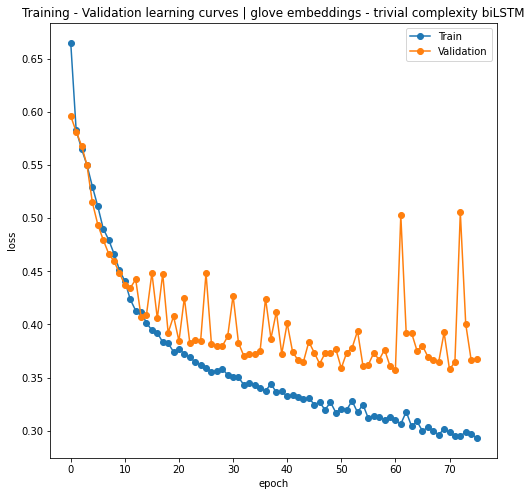

[I 2023-01-09 20:47:24,048] Trial 0 finished with value: 0.3568256753821706 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.0, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.00010705080373221575, 'wd': 7.605307121989588e-05}. Best is trial 0 with value: 0.3568256753821706.

 SentimentClassifier_baseline_biLSTM_glove(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 6m 44s
	Train Loss: 0.620
	 Val. Loss: 0.584

Epoch: 02 | Epoch Time: 10m 25s
	Train Loss: 0.613
	 Val. Loss: 0.659

Epoch: 03 | Epoch Time: 2m 54s
	Train Loss: 0.608
	 Val. Loss: 0.551

Epoch: 

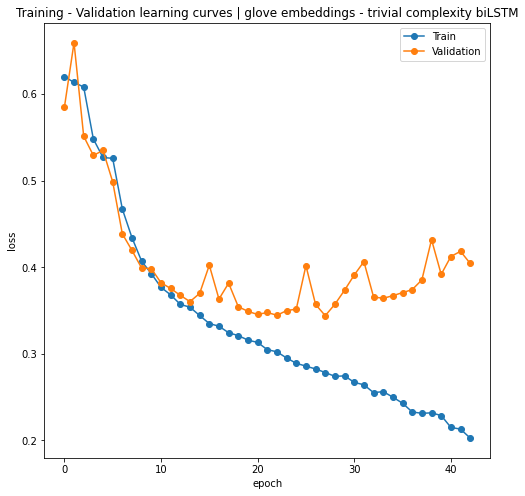

[I 2023-01-09 22:52:29,359] Trial 1 finished with value: 0.34410606931115306 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.0, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.00040818427120953564, 'wd': 6.125260668293882e-05}. Best is trial 1 with value: 0.34410606931115306.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity = "trivial"
method = "biLSTM"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=None
)

study.optimize(trial_validation_loss, n_trials=2, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/best_{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt")


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:    0
  Number of complete trials:  2

Best trial: 

Best model validation loss value: 0.34410606931115306

Best trial number: 1

Best model parameters: 

activation: ReLU

lstm_hidden_units: 64

num_lstm_layers: 2

lstm_dropout: 0.0

dropout_rate: 0.25

optimizer: Adam

lr: 0.00040818427120953564

wd: 6.125260668293882e-05


Evaluation metrics: glove_embeddings_trivial_complexity_nn_biLSTM 
Best parameters: | activation: ReLU | lstm_hidden_units: 64 | num_lstm_layers: 2 | lstm_dropout: 0.0 | dropout_rate: 0.25 | optimizer: Adam | lr: 0.00040818427120953564 | wd: 6.125260668293882e-05 

precision score: 0.8436 
recall_score: 0.8370 
roc score: 0.8409 
f1_score: 0.8403

model bias: 0.0
model variance: 0.25


              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      2700
    positive       0.84      0.84      0.84      2700

    accuracy                           0.84      5400
   macro avg       0.84      0.84      0.84      5400
weighted avg       0.84      0.84      0.84      5400





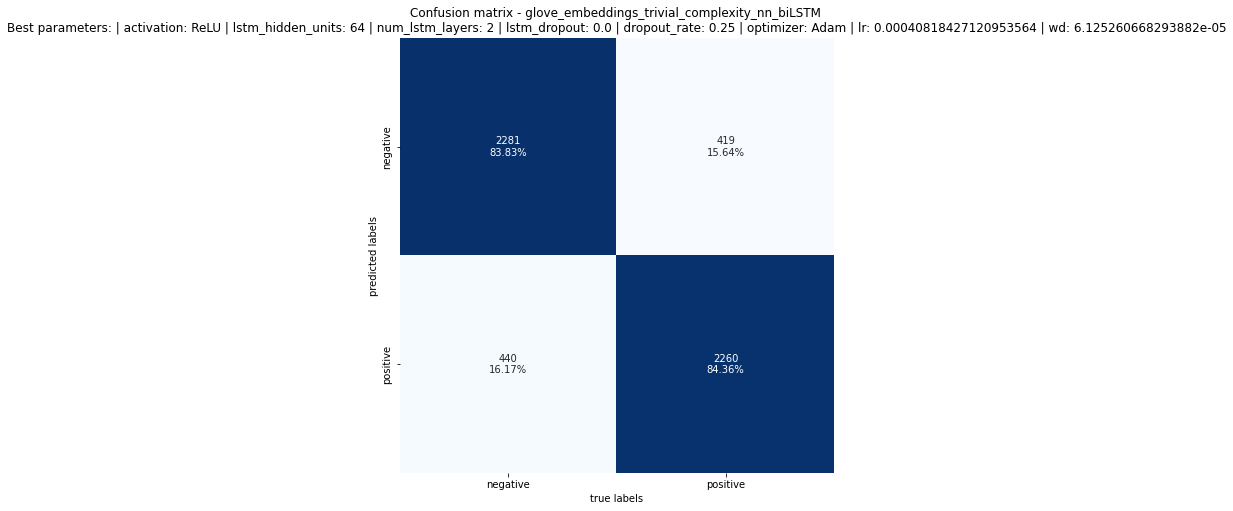

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = f"{embeddings_type}_embeddings_{complexity}_complexity_nn_{method} \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

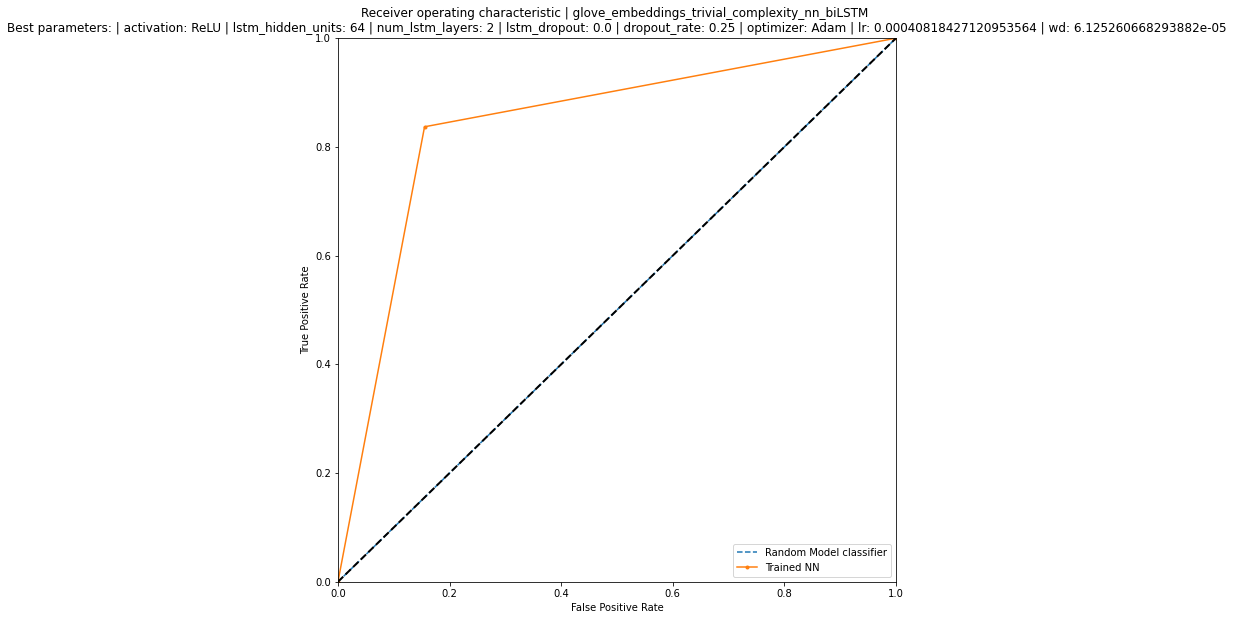

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---
### LSTM Baseline model - GloVe embeddings v2

Baseline model architecture including the following layers in mostly default parameter values:
- (1) Embeddings layer
- (1) LSTM layer (BiDirectional)
- (1) Dropout layer
- (1) Linear output layer
- Added learning rate scheduler to minimize the learning rate every k epochs.

Batch_size (training = 128, validation = 16) <br>
Embedding_dim = 50<br>
LSTM_layers = 2<br>
Bi-directional = True<br>
Dropout propability (lstm layer) = 0.15<br>
Dropout propability (dense layer) = 0.25<br>

In [ ]:
class SentimentClassifier_baseline_biLSTM_glove_v2(nn.Module):

  def __init__(self, trial, non_contributive_token, vector_length, output_dim, activation, batch_size, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_baseline_biLSTM_glove_v2, self).__init__()

    self.layers = []
    self.padding_idx = non_contributive_token
    self.vector_length = vector_length

    #embedding layer
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=self.padding_idx)

    #bidirectional LSTM layer
    self.lstm_hidden_units = trial.suggest_int("lstm_hidden_units", 64, 64)
    self.num_lstm_layers = trial.suggest_int("num_lstm_layers", 2, 2)
    self.lstm_dropout = trial.suggest_float("lstm_dropout", 0.15, 0.15)

    self.biLSTM = nn.LSTM(
        input_size = embedding_dimension,
        hidden_size = self.lstm_hidden_units,
        num_layers = self.num_lstm_layers,
        batch_first = True,
        dropout = self.lstm_dropout,
        bidirectional = True
    )
    self.num_directions = 2 #for bidirectional model.

    #Specify number of additional dense/linear layers
    self.n_layers = 0

    #dropout layer
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.25)
    self.dropout_layer = nn.Dropout(self.dropout_rate)

    #output layer
    self.output_layer = nn.Linear(self.lstm_hidden_units*self.num_directions, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      n = module.in_features
      initrange = 1.0/np.sqrt(n)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        #module.bias.data.zero_()
        module.bias.data.fill_(0)

  def forward(self, text):
    """
    source (1): https://github.com/Huffon/pytorch-sentiment-analysis-kor/blob/master/models/bidirectional_lstm.py
    source (2): https://www.analyticsvidhya.com/blog/2021/09/sentiment-analysis-with-lstm-and-torchtext-with-code-and-explanation/
    """
    embedded = self.embedding(text)

    hidden_state = torch.zeros(self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)
    cell = torch.zeros( self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)

    out_lstm, (hidden_state, cell) = self.biLSTM(embedded, (hidden_state, cell))
    
    hidden_state = self.dropout_layer(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))

    output_layer = self.output_layer(hidden_state)
    output_layer_predictions = self.activation_output(output_layer)
    
    return output_layer_predictions

In [ ]:
seed = 11
def objective(trial):
  torch.manual_seed(seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_baseline_biLSTM_glove_v2(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam"])
  learning_rate = trial.suggest_float('lr', 5e-3, 1e-2)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #halve learning rate every 10 epochs

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 80
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove_v2"
    complexity = "trivial"
    method = "biLSTM"
    torch.save(
      model.state_dict(),
      f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt"
    )

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = f"{embeddings_type} embeddings - {complexity} complexity {method}"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2023-01-11 11:39:43,015] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove_v2 embeddings


  0%|          | 0/2 [00:00<?, ?it/s]


 SentimentClassifier_baseline_biLSTM_glove_v2(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.005901348444383846

Epoch: 01 | Epoch Time: 9m 3s
	Train Loss: 0.595
	 Val. Loss: 0.525
Epoch-2 lr: 0.005901348444383846

Epoch: 02 | Epoch Time: 4m 5s
	Train Loss: 0.501
	 Val. Loss: 0.605
Epoch-3 lr: 0.005901348444383846

Epoch: 03 | Epoch Time: 2m 59s
	Train Loss: 0.419
	 Val. Loss: 0.421
Epoch-4 lr: 0.005901348444383846

Epoch: 04 | Epoch Time: 2m 33s
	Train Loss: 0.382
	 Val. Loss: 0.402
Epoch-5 lr: 0.005901348444383846

Epoch: 05 | Epoch Time: 5m 46s
	Train Loss: 0.359
	 Val. Loss: 0.361
Epoch-6 lr: 0.005901348

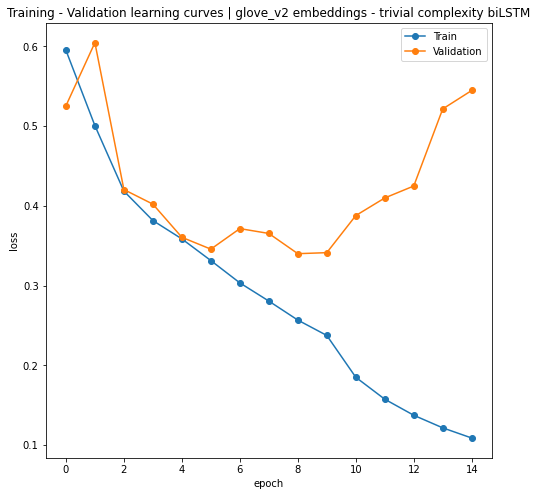

[I 2023-01-11 13:26:56,447] Trial 0 finished with value: 0.34010470119015923 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.15, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.005901348444383846, 'wd': 1.9475241487624583e-06}. Best is trial 0 with value: 0.34010470119015923.

 SentimentClassifier_baseline_biLSTM_glove_v2(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.007316092632491724

Epoch: 01 | Epoch Time: 8m 50s
	Train Loss: 0.609
	 Val. Loss: 0.445
Epoch-2 lr: 0.007316092632491724

Epoch: 02 | Epoch Time: 8m 58s
	Train Loss: 0.432
	 Val. Loss: 

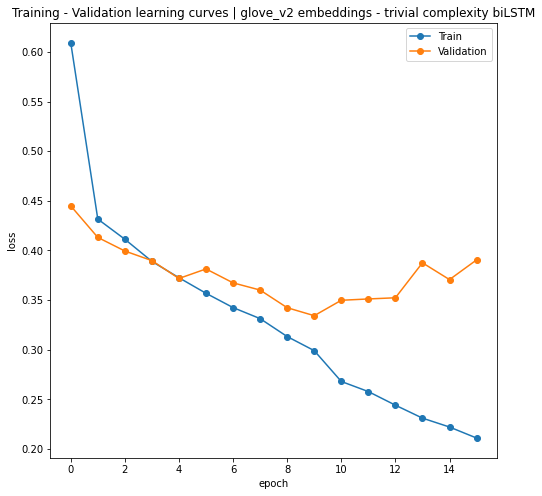

[I 2023-01-11 16:11:31,426] Trial 1 finished with value: 0.33432867763371305 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.15, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.007316092632491724, 'wd': 7.249339291921478e-05}. Best is trial 1 with value: 0.33432867763371305.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove_v2"
complexity = "trivial"
method = "biLSTM"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=None
)

study.optimize(trial_validation_loss, n_trials=2, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt")


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:    0
  Number of complete trials:  2

Best trial: 

Best model validation loss value: 0.33432867763371305

Best trial number: 1

Best model parameters: 

activation: ReLU

lstm_hidden_units: 64

num_lstm_layers: 2

lstm_dropout: 0.15

dropout_rate: 0.25

optimizer: Adam

lr: 0.007316092632491724

wd: 7.249339291921478e-05


Evaluation metrics: glove_v2_embeddings_trivial_complexity_nn_biLSTM 
Best parameters: | activation: ReLU | lstm_hidden_units: 64 | num_lstm_layers: 2 | lstm_dropout: 0.15 | dropout_rate: 0.25 | optimizer: Adam | lr: 0.007316092632491724 | wd: 7.249339291921478e-05 

precision score: 0.8549 
recall_score: 0.8489 
roc score: 0.8524 
f1_score: 0.8519

model bias: 0.0
model variance: 0.25


              precision    recall  f1-score   support

    negative       0.85      0.86      0.85      2700
    positive       0.85      0.85      0.85      2700

    accuracy                           0.85      5400
   macro avg       0.85      0.85      0.85      5400
weighted avg       0.85      0.85      0.85      5400





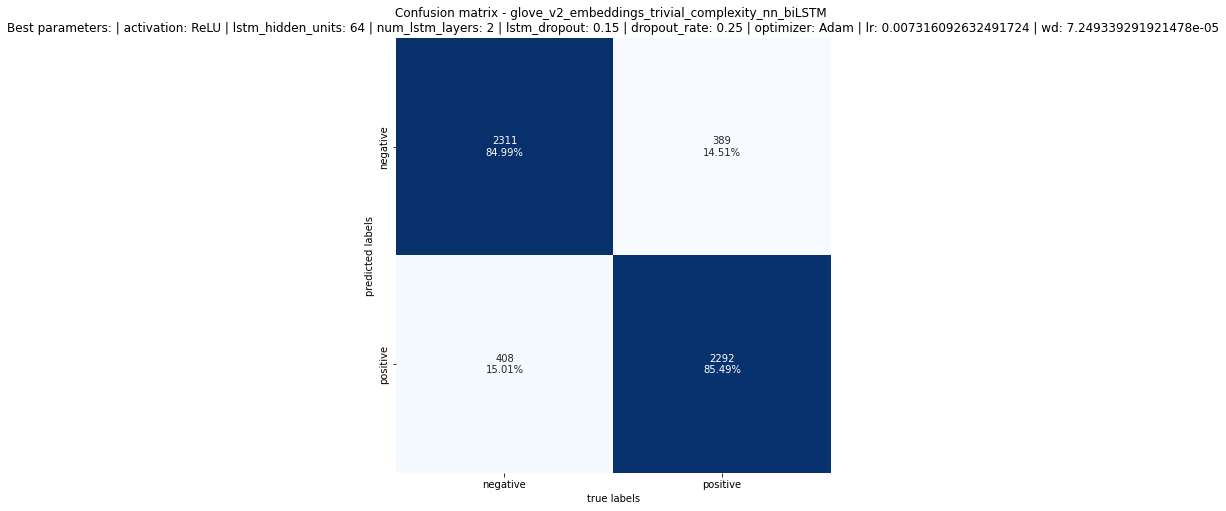

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = f"{embeddings_type}_embeddings_{complexity}_complexity_nn_{method} \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

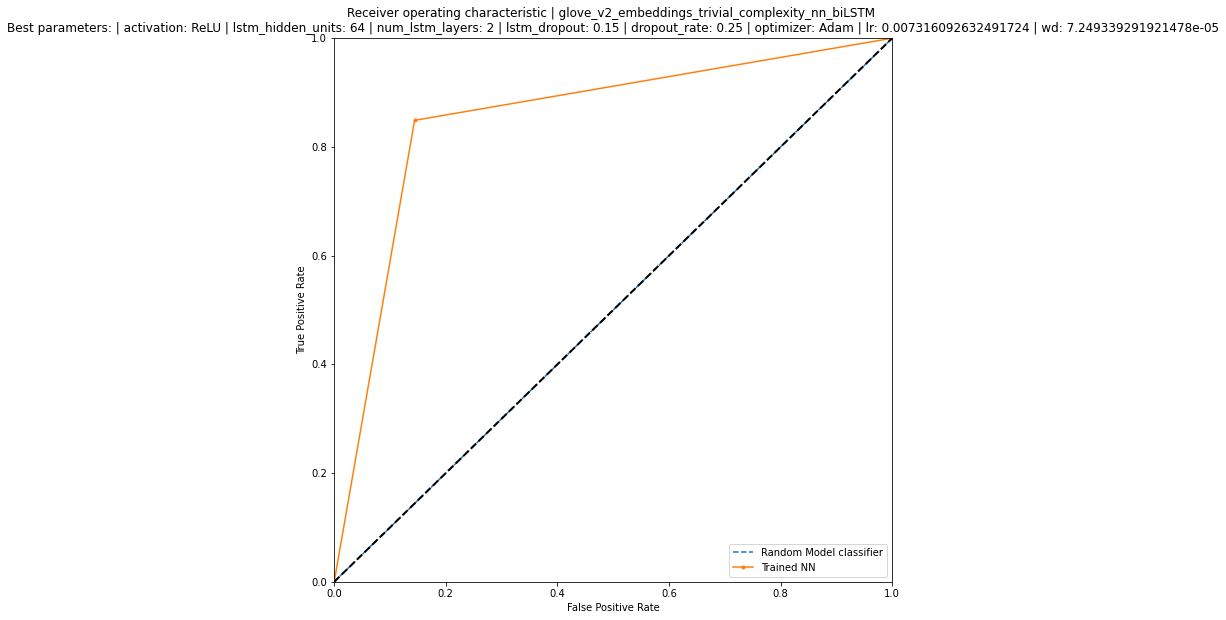

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---
### LSTM Baseline model - GloVe embeddings v3

Baseline model architecture including the following layers in mostly default parameter values:
- (1) Embeddings layer
- (1) LSTM layer (BiDirectional)
- (1) Dropout layer
- (1) Linear output layer
- Added learning rate scheduler to minimize the learning rate every k epochs.

Batch_size (training = 128, validation = 16) <br>
Embedding_dim = 50<br>
LSTM_layers = 2<br>
Bi-directional = True<br>
Dropout propability (lstm layer) = 0.15<br>
Dropout propability (dense layer) = 0.25<br>

Based on the results of the previous two baseline GloVe models I have increased the number of epochs to adjust the learning rate from 10 to 20 epochs. And also I have increased the gamma value of the lr scheduler from 0.5 to 0.85 in order to make smaller steps of changes in the learning rate.

In [ ]:
seed = 12
def objective(trial):
  torch.manual_seed(seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_baseline_biLSTM_glove_v2(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam"])
  learning_rate = trial.suggest_float('lr', 5e-3, 1e-2)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.85) #halve learning rate every 10 epochs

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 80
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove_v3"
    complexity = "trivial"
    method = "biLSTM"
    torch.save(
      model.state_dict(),
      f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt"
    )

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = f"{embeddings_type} embeddings - {complexity} complexity {method}"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2023-01-11 21:32:47,721] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove_v3 embeddings
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/2 [00:00<?, ?it/s]


 SentimentClassifier_baseline_biLSTM_glove_v2(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.005770814211898362

Epoch: 01 | Epoch Time: 10m 31s
	Train Loss: 0.555
	 Val. Loss: 0.429
Epoch-2 lr: 0.005770814211898362

Epoch: 02 | Epoch Time: 11m 25s
	Train Loss: 0.396
	 Val. Loss: 0.396
Epoch-3 lr: 0.005770814211898362

Epoch: 03 | Epoch Time: 11m 18s
	Train Loss: 0.356
	 Val. Loss: 0.362
Epoch-4 lr: 0.005770814211898362

Epoch: 04 | Epoch Time: 11m 17s
	Train Loss: 0.333
	 Val. Loss: 0.376
Epoch-5 lr: 0.005770814211898362

Epoch: 05 | Epoch Time: 11m 12s
	Train Loss: 0.317
	 Val. Loss: 0.329
Epoch-6 lr: 0.00

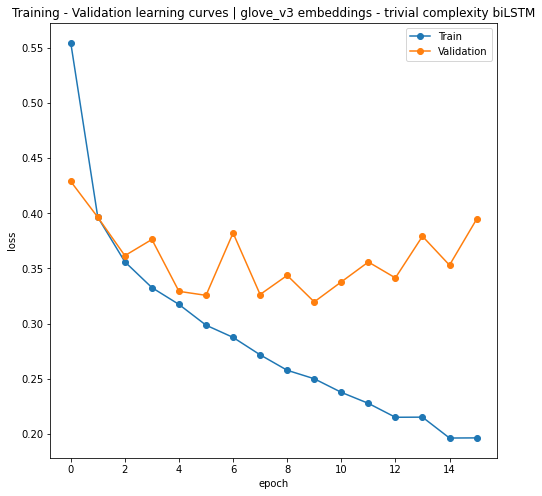

[I 2023-01-12 00:25:12,718] Trial 0 finished with value: 0.3197022771293467 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.15, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.005770814211898362, 'wd': 7.400496965154048e-05}. Best is trial 0 with value: 0.3197022771293467.

 SentimentClassifier_baseline_biLSTM_glove_v2(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.006316575075925673

Epoch: 01 | Epoch Time: 11m 0s
	Train Loss: 0.578
	 Val. Loss: 0.541
Epoch-2 lr: 0.006316575075925673

Epoch: 02 | Epoch Time: 2m 49s
	Train Loss: 0.449
	 Val. Loss: 0.4

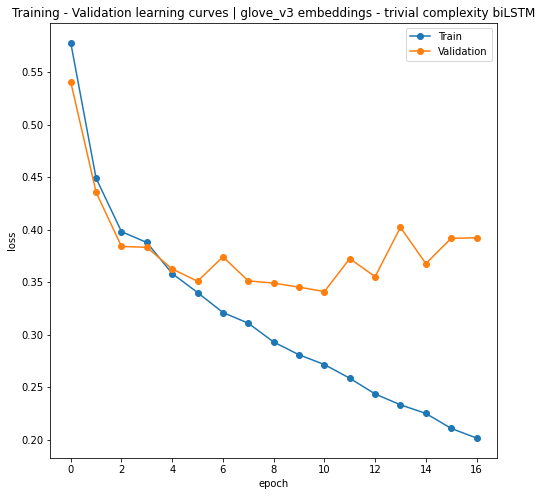

[I 2023-01-12 02:52:57,636] Trial 1 finished with value: 0.34095305881716986 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.15, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.006316575075925673, 'wd': 5.3373939338029776e-05}. Best is trial 0 with value: 0.3197022771293467.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove_v3"
complexity = "trivial"
method = "biLSTM"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=None
)

study.optimize(trial_validation_loss, n_trials=2, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.pt")


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:    0
  Number of complete trials:  2

Best trial: 

Best model validation loss value: 0.3197022771293467

Best trial number: 0

Best model parameters: 

activation: ReLU

lstm_hidden_units: 64

num_lstm_layers: 2

lstm_dropout: 0.15

dropout_rate: 0.25

optimizer: Adam

lr: 0.005770814211898362

wd: 7.400496965154048e-05


Evaluation metrics: glove_v3_embeddings_trivial_complexity_nn_biLSTM 
Best parameters: | activation: ReLU | lstm_hidden_units: 64 | num_lstm_layers: 2 | lstm_dropout: 0.15 | dropout_rate: 0.25 | optimizer: Adam | lr: 0.005770814211898362 | wd: 7.400496965154048e-05 

precision score: 0.8595 
recall_score: 0.8563 
roc score: 0.8581 
f1_score: 0.8579

model bias: 0.0
model variance: 0.25


              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      2700
    positive       0.86      0.86      0.86      2700

    accuracy                           0.86      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.86      0.86      0.86      5400





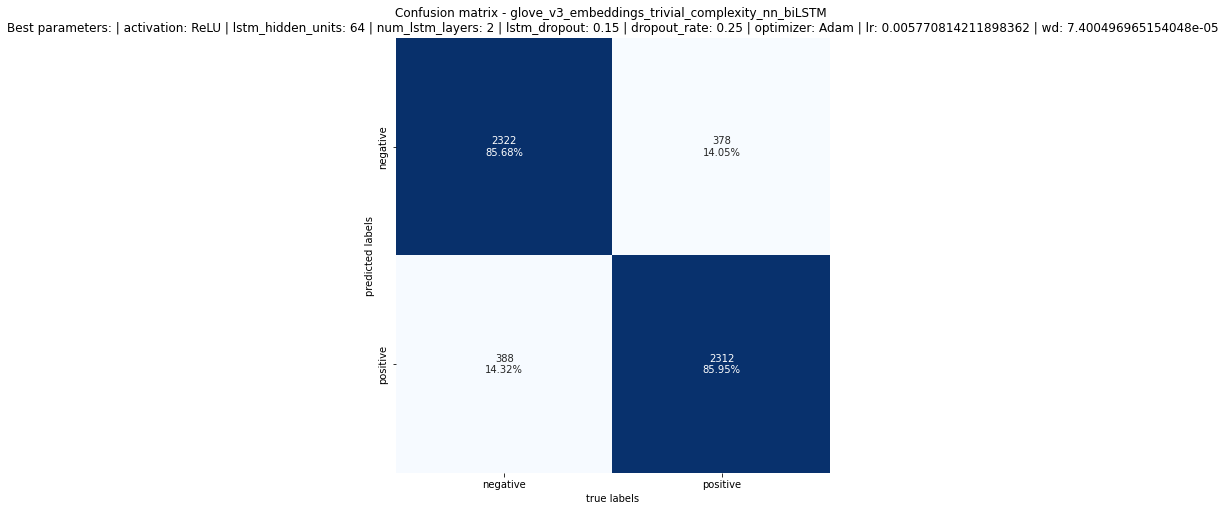

In [ ]:
label_names = ["negative", "positive"]

best_model_study=joblib.load("drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_v3_embeddings_trivial_complexity_nn_biLSTM_0_study_optuna.pkl")
trial=best_model_study.best_trial

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

best_model = SentimentClassifier_baseline_biLSTM_glove_v2(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )
best_model.load_state_dict(torch.load("drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_glove_v3_embeddings_trivial_complexity_nn_biLSTM_0.pt"))

graph_name = f"{embeddings_type}_embeddings_{complexity}_complexity_nn_{method} \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

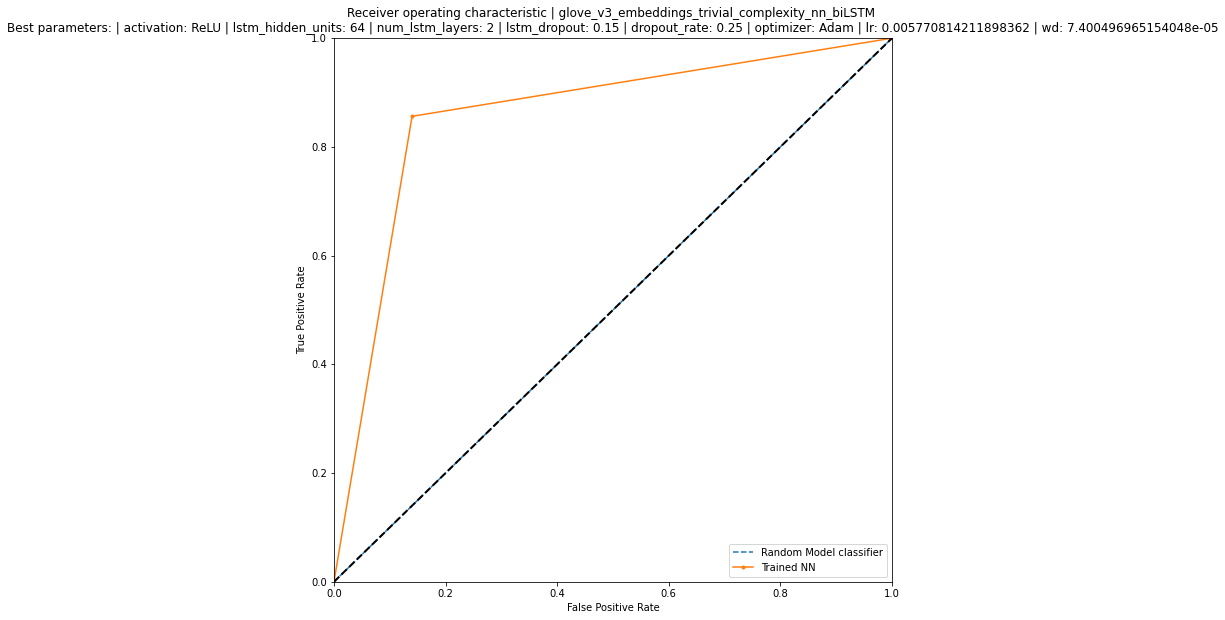

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---
### LSTM Baseline model - GloVe embeddings v4

For this experiment I will keep everything in the architecture the same and I will only change the following (keeping in mind the overfitting learning curves of the previous experiments):

- Add gradient clipping in the baseline model. Based on the prediction results, the training loss and the overall performance of the previous experiments it seems that gradient clipping it's not needed. However, for testing purposes I will apply it on the training of the fourth experiment.
- Dropout probability (LSTM layer) = 0.25 (from 0.15 - 3rd experiment)<br>
- Dropout probability (dense layer) = 0.50 (from 0.25 - 3rd experiment)<br>
- Drop the step_size of the learning rate scheduler from 20 to 15 epochs. In order to change the learning rate sooner than in the third experiment.

In [ ]:
seed = 13
def objective(trial):
  torch.manual_seed(seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_baseline_biLSTM_glove_v2(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam"])
  learning_rate = trial.suggest_float('lr', 5e-3, 1e-2)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.85) #halve learning rate every 10 epochs
  clip_coef = trial.suggest_int('clip_coef', 5, 5)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 80
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, clip_coef, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove_v4"
    complexity = "trivial"
    method = "biLSTM"
    torch.save(
      model.state_dict(),
      f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt"
    )

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = f"{embeddings_type} embeddings - {complexity} complexity {method}"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2023-01-12 11:16:24,784] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove_v4 embeddings
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/2 [00:00<?, ?it/s]


 SentimentClassifier_baseline_biLSTM_glove_v2(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.008888512052869101

Epoch: 01 | Epoch Time: 5m 37s
	Train Loss: 0.605
	 Val. Loss: 0.460
Epoch-2 lr: 0.008888512052869101

Epoch: 02 | Epoch Time: 2m 2s
	Train Loss: 0.466
	 Val. Loss: 0.422
Epoch-3 lr: 0.008888512052869101

Epoch: 03 | Epoch Time: 2m 3s
	Train Loss: 0.410
	 Val. Loss: 0.399
Epoch-4 lr: 0.008888512052869101

Epoch: 04 | Epoch Time: 2m 3s
	Train Loss: 0.377
	 Val. Loss: 0.358
Epoch-5 lr: 0.008888512052869101

Epoch: 05 | Epoch Time: 2m 2s
	Train Loss: 0.341
	 Val. Loss: 0.341
Epoch-6 lr: 0.00888851205

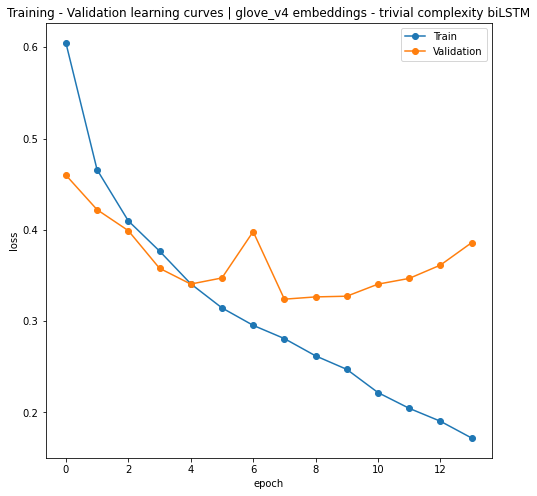

[I 2023-01-12 12:17:51,128] Trial 0 finished with value: 0.324083729901097 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.15, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.008888512052869101, 'wd': 2.375412200349123e-05, 'clip_coef': 5}. Best is trial 0 with value: 0.324083729901097.

 SentimentClassifier_baseline_biLSTM_glove_v2(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 158,849 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.009121392663306842

Epoch: 01 | Epoch Time: 6m 8s
	Train Loss: 0.651
	 Val. Loss: 0.709
Epoch-2 lr: 0.009121392663306842

Epoch: 02 | Epoch Time: 2m 35s
	Train Loss: 0.556
	 V

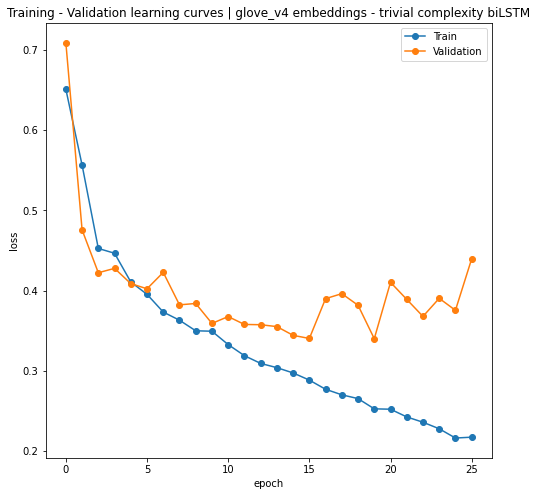

[I 2023-01-12 13:33:20,632] Trial 1 finished with value: 0.3399555269967426 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 64, 'num_lstm_layers': 2, 'lstm_dropout': 0.15, 'dropout_rate': 0.25, 'optimizer': 'Adam', 'lr': 0.009121392663306842, 'wd': 9.657491980429997e-05, 'clip_coef': 5}. Best is trial 0 with value: 0.324083729901097.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove_v4"
complexity = "trivial"
method = "biLSTM"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=None
)

study.optimize(trial_validation_loss, n_trials=2, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.pt")


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:    0
  Number of complete trials:  2

Best trial: 

Best model validation loss value: 0.324083729901097

Best trial number: 0

Best model parameters: 

activation: ReLU

lstm_hidden_units: 64

num_lstm_layers: 2

lstm_dropout: 0.15

dropout_rate: 0.25

optimizer: Adam

lr: 0.008888512052869101

wd: 2.375412200349123e-05

clip_coef: 5


Evaluation metrics: glove_v4_embeddings_trivial_complexity_nn_biLSTM 
Best parameters: | activation: ReLU | lstm_hidden_units: 64 | num_lstm_layers: 2 | lstm_dropout: 0.15 | dropout_rate: 0.25 | optimizer: Adam | lr: 0.008888512052869101 | wd: 2.375412200349123e-05 | clip_coef: 5 

precision score: 0.8765 
recall_score: 0.8415 
roc score: 0.8615 
f1_score: 0.8587

model bias: 0.0008
model variance: 0.2496


              precision    recall  f1-score   support

    negative       0.85      0.88      0.86      2700
    positive       0.88      0.84      0.86      2700

    accuracy                           0.86      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.86      0.86      0.86      5400





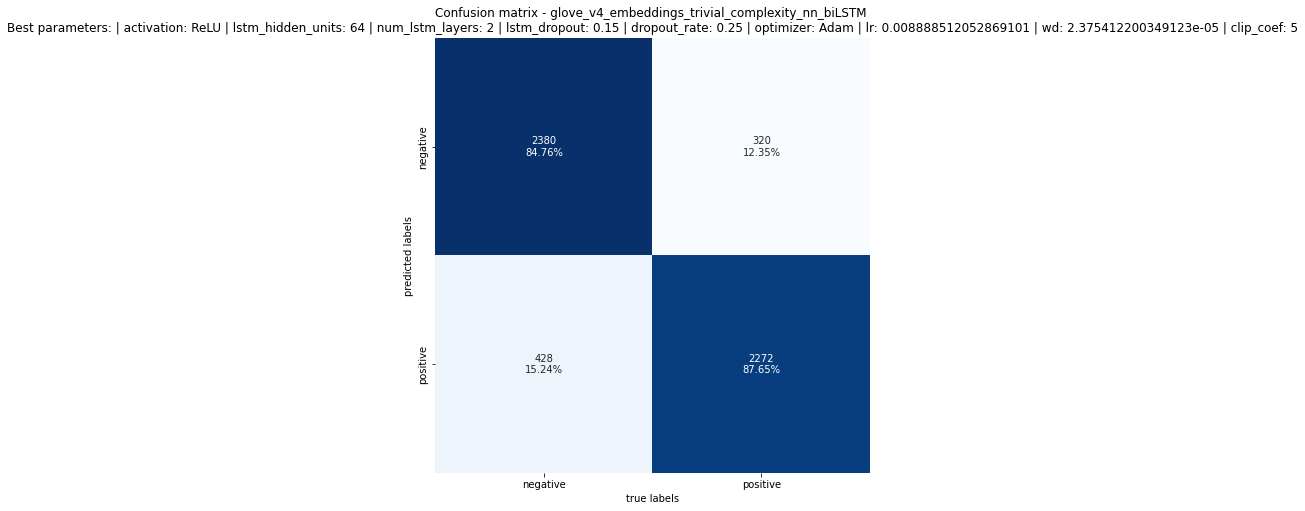

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = f"{embeddings_type}_embeddings_{complexity}_complexity_nn_{method} \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

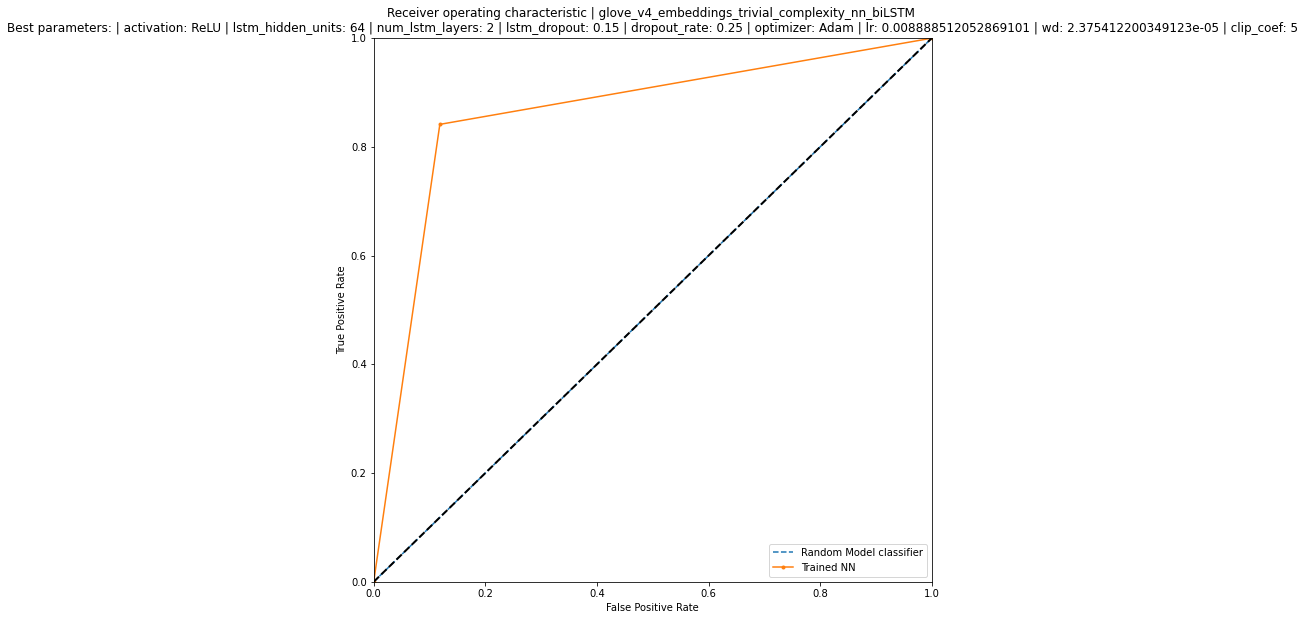

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---
### LSTM Advanced complexity model - GloVe embeddings v5

After the experimentation with the baseline model I will proceed the hyper-parameter tuning of the baseline model architecture by also adding extra Linear layers as a hyper-parameter. For example, in the baseline model architecture I had only 1 ```nn.Linear``` layer. In the hyper-parameter tuning I will also test different scenarios with additional linear layers.

You may find below a brief description of the hyper-parameters tuned:
- lstm_hidden_units
- num_lstm_layers = number of stacked lstm layers
- lstm_dropout
- n_layers = number of hidden/dense ```nn.Linear``` layers
- lstm_hidden_units = hiddent units of the linear layers
- dropout_probability of dropout layer
- activation function of the hidden layers
- learning rate
- weight decay if the learning rate
- clip coef of the gradient clipping method

In [ ]:
class SentimentClassifier_baseline_biLSTM_glove_v5(nn.Module):

  def __init__(self, trial, non_contributive_token, output_dim, activation, batch_size, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_baseline_biLSTM_glove_v5, self).__init__()

    self.layers = []
    self.padding_idx = non_contributive_token

    #embedding layer
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=self.padding_idx)

    #bidirectional LSTM layer
    self.lstm_hidden_units = trial.suggest_int("lstm_hidden_units", 64, 128)
    self.num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 3)
    self.lstm_dropout = trial.suggest_float("lstm_dropout", 0.15, 0.30)
    #linear_hidden_units = trial.suggest_int("linear_hidden_units", 128, 256)

    self.biLSTM = nn.LSTM(
      input_size = embedding_dimension,
      hidden_size = self.lstm_hidden_units,
      num_layers = self.num_lstm_layers,
      batch_first = True,
      dropout = self.lstm_dropout,
      bidirectional = True
    )
    self.num_directions = 2 #for bidirectional models.

    #dropout layer
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_layer = nn.Dropout(self.dropout_rate)

    #Specify number of additional dense/linear layers
    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers !=0:
      
      for i in range(self.n_layers):

        out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 16, 64)
        
        if i == 0:
          linear_hidden_units = self.lstm_hidden_units*self.num_directions
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
          linear_hidden_units = out_features
        else:
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
        #self.layers.append(nn.BatchNorm1d(3*out_features))
        
        if activation.lower() == "relu":
            self.layers.append(nn.ReLU())
        else:
            self.layers.append(nn.Tanh())
        
        self.layers.append(nn.Dropout(self.dropout_rate))
        linear_hidden_units = out_features
    
    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #output layer
    if self.n_layers !=0:
      self.output_layer = nn.Linear(linear_hidden_units, output_dim)
    else:
      self.output_layer = nn.Linear(self.lstm_hidden_units*self.num_directions, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      n = module.in_features
      initrange = 1.0/np.sqrt(n)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        #module.bias.data.zero_()
        module.bias.data.fill_(0)

  def forward(self, text):
    """
    source (1): https://github.com/Huffon/pytorch-sentiment-analysis-kor/blob/master/models/bidirectional_lstm.py
    source (2): https://www.analyticsvidhya.com/blog/2021/09/sentiment-analysis-with-lstm-and-torchtext-with-code-and-explanation/
    """
    embedded = self.embedding(text)

    hidden_state = torch.zeros(self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)
    cell = torch.zeros( self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)

    out_lstm, (hidden_state, cell) = self.biLSTM(embedded, (hidden_state, cell))
    
    hidden_state = self.dropout_layer(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))

    if self.n_layers !=0:
      for layer in range(len(self.layers)):
        if layer ==0:
          dense_layer = self.layers[layer](hidden_state)
        else:
          dense_layer = self.layers[layer](dense_layer)
      output_layer = self.output_layer(dense_layer)
    else:
      output_layer = self.output_layer(hidden_state)
    
    output_layer_predictions = self.activation_output(output_layer)
    
    return output_layer_predictions

In [ ]:
seed = 14
def objective(trial):
  torch.manual_seed(seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_baseline_biLSTM_glove_v5(
    trial,
    non_contributive_token=glove_vocab_50_v2[unk_token],
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors_50_v2.vectors,
    embedding_dimension=glove_vectors_50_v2.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam"])
  learning_rate = trial.suggest_float('lr', 5e-3, 1e-2)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  clip_coef = trial.suggest_float('clip_coef', 1.5, 5.5)

  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.85)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 80
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, clip_coef, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove_v5"
    complexity = "trivial"
    method = "biLSTM"
    torch.save(
      model.state_dict(),
      f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number}.pt"
    )

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = f"{embeddings_type} embeddings - {complexity} complexity {method}"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2023-01-13 08:03:19,861] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove_v5 embeddings


  0%|          | 0/8 [00:00<?, ?it/s]


 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 97, num_layers=3, batch_first=True, dropout=0.2805641528587219, bidirectional=True)
  (dropout_layer): Dropout(p=0.25402347426490895, inplace=False)
  (fully_connected_layer_0): Linear(in_features=194, out_features=62, bias=True)
  (fully_connected_layer_1): ReLU()
  (fully_connected_layer_2): Dropout(p=0.25402347426490895, inplace=False)
  (output_layer): Linear(in_features=62, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 582,513 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.007565583561339436

Epoch: 01 | Epoch Time: 9m 3s
	Train Loss: 0.673
	 Val. Loss: 0.649
Epoch-2 lr: 0.007565583561339436

Epoch: 02 | Epoch Time: 7m 4s
	Train Loss: 0.526
	 Val. Loss: 0.448
Epoch-3 lr: 0.007565583561339436

Epoch: 03 | Epoch Time: 7m 26s
	Train Loss: 0.412
	 Val. Loss: 0.391


Exception ignored in: <function tqdm.__del__ at 0x7f2f5787dc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Epoch-4 lr: 0.007565583561339436

Epoch: 04 | Epoch Time: 7m 45s
	Train Loss: 0.382
	 Val. Loss: 0.386
Epoch-5 lr: 0.007565583561339436

Epoch: 05 | Epoch Time: 8m 25s
	Train Loss: 0.354
	 Val. Loss: 0.380
Epoch-6 lr: 0.007565583561339436

Epoch: 06 | Epoch Time: 10m 10s
	Train Loss: 0.336
	 Val. Loss: 0.352
Epoch-7 lr: 0.007565583561339436

Epoch: 07 | Epoch Time: 8m 59s
	Train Loss: 0.311
	 Val. Loss: 0.324
Epoch-8 lr: 0.007565583561339436

Epoch: 08 | Epoch Time: 9m 26s
	Train Loss: 0.308
	 Val. Loss: 0.362
Epoch-9 lr: 0.007565583561339436

Epoch: 09 | Epoch Time: 15m 32s
	Train Loss: 0.286
	 Val. Loss: 0.340
Epoch-10 lr: 0.007565583561339436

Epoch: 10 | Epoch Time: 25m 44s
	Train Loss: 0.277
	 Val. Loss: 0.439
Epoch-11 lr: 0.007565583561339436

Epoch: 11 | Epoch Time: 24m 36s
	Train Loss: 0.262
	 Val. Loss: 0.334
Epoch-12 lr: 0.007565583561339436

Epoch: 12 | Epoch Time: 25m 4s
	Train Loss: 0.239
	 Val. Loss: 0.363
Epoch-13 lr: 0.007565583561339436


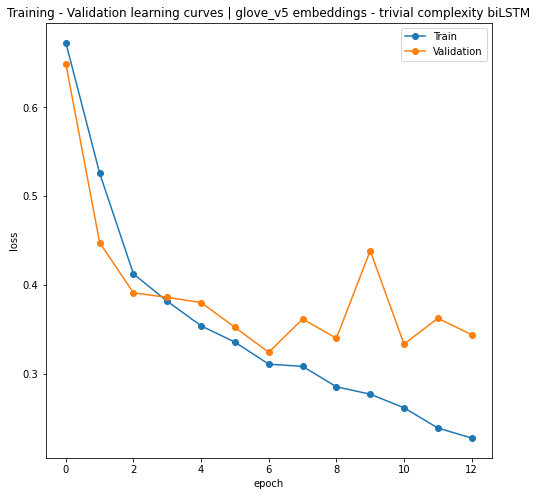

[I 2023-01-13 11:08:27,471] Trial 0 finished with value: 0.32427659698508005 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 97, 'num_lstm_layers': 3, 'lstm_dropout': 0.2805641528587219, 'dropout_rate': 0.25402347426490895, 'n_layers': 1, 'n_units_hidden_layer_0': 62, 'optimizer': 'Adam', 'lr': 0.007565583561339436, 'wd': 3.1828442487209865e-05, 'clip_coef': 3.6567997497025924}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 78, num_layers=3, batch_first=True, dropout=0.20133819384220264, bidirectional=True)
  (dropout_layer): Dropout(p=0.5194444245335723, inplace=False)
  (output_layer): Linear(in_features=156, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 375,805 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.008365762390902627

Epoch: 01 | Epoch Time: 8m 41s

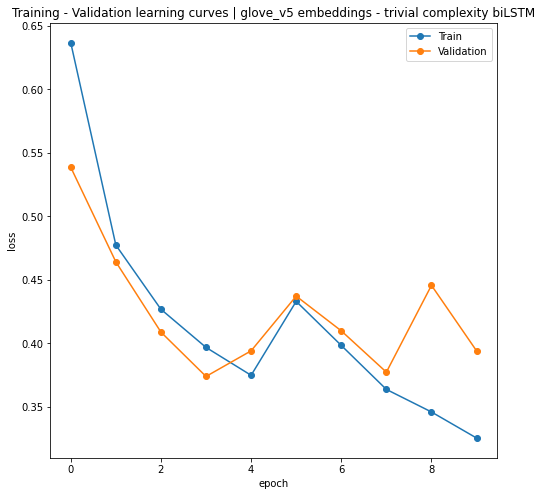

[I 2023-01-13 12:49:05,763] Trial 1 finished with value: 0.37400480088862503 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 78, 'num_lstm_layers': 3, 'lstm_dropout': 0.20133819384220264, 'dropout_rate': 0.5194444245335723, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.008365762390902627, 'wd': 2.1002426217873817e-05, 'clip_coef': 5.230230371514848}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 88, num_layers=3, batch_first=True, dropout=0.26447085027682826, bidirectional=True)
  (dropout_layer): Dropout(p=0.6852497276358751, inplace=False)
  (output_layer): Linear(in_features=176, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 473,265 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.006500459901968919

Epoch: 01 | Epoch Time: 9m 26s
	Train Loss: 0.626
	 Val. Loss

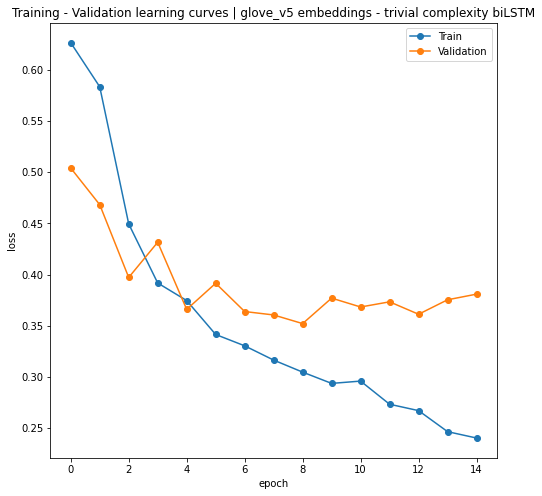

[I 2023-01-13 14:48:59,749] Trial 2 finished with value: 0.3520742593841119 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 88, 'num_lstm_layers': 3, 'lstm_dropout': 0.26447085027682826, 'dropout_rate': 0.6852497276358751, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.006500459901968919, 'wd': 4.7490576595046856e-05, 'clip_coef': 4.191746876666343}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 80, num_layers=3, batch_first=True, dropout=0.24855000890613937, bidirectional=True)
  (dropout_layer): Dropout(p=0.34100387885594713, inplace=False)
  (fully_connected_layer_0): Linear(in_features=160, out_features=59, bias=True)
  (fully_connected_layer_1): ReLU()
  (fully_connected_layer_2): Dropout(p=0.34100387885594713, inplace=False)
  (output_layer): Linear(in_features=59, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)


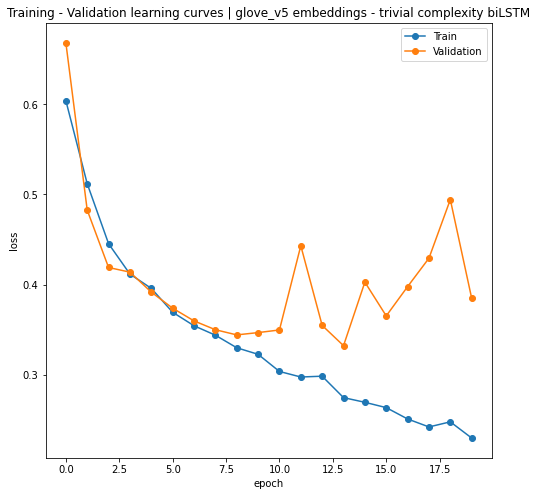

[I 2023-01-13 20:06:10,171] Trial 3 finished with value: 0.33220103044401517 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 80, 'num_lstm_layers': 3, 'lstm_dropout': 0.24855000890613937, 'dropout_rate': 0.34100387885594713, 'n_layers': 1, 'n_units_hidden_layer_0': 59, 'optimizer': 'Adam', 'lr': 0.005416745805248784, 'wd': 7.465641201404082e-05, 'clip_coef': 1.7494001959339056}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 111, num_layers=3, batch_first=True, dropout=0.21118737201774918, bidirectional=True)
  (dropout_layer): Dropout(p=0.7456914994492405, inplace=False)
  (fully_connected_layer_0): Linear(in_features=222, out_features=25, bias=True)
  (fully_connected_layer_1): ReLU()
  (fully_connected_layer_2): Dropout(p=0.7456914994492405, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
  (activation): ReLU()
  (a

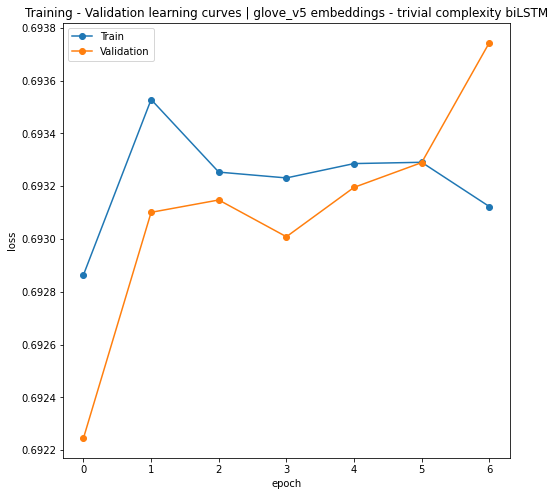

[I 2023-01-13 21:31:01,789] Trial 4 finished with value: 0.6922458979216489 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 111, 'num_lstm_layers': 3, 'lstm_dropout': 0.21118737201774918, 'dropout_rate': 0.7456914994492405, 'n_layers': 1, 'n_units_hidden_layer_0': 25, 'optimizer': 'Adam', 'lr': 0.006758132360496913, 'wd': 7.148116664252599e-05, 'clip_coef': 2.9297414530070625}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 67, batch_first=True, dropout=0.2998206917347471, bidirectional=True)
  (dropout_layer): Dropout(p=0.39395242830865707, inplace=False)
  (fully_connected_layer_0): Linear(in_features=134, out_features=52, bias=True)
  (fully_connected_layer_1): ReLU()
  (fully_connected_layer_2): Dropout(p=0.39395242830865707, inplace=False)
  (output_layer): Linear(in_features=52, out_features=1, bias=True)
  (activation): ReLU()
  (activation_outpu

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2998206917347471 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch-1 lr: 0.009718394753726798

Epoch: 01 | Epoch Time: 2m 14s
	Train Loss: 0.531
	 Val. Loss: 0.415
Epoch-2 lr: 0.009718394753726798

Epoch: 02 | Epoch Time: 1m 39s
	Train Loss: 0.413
	 Val. Loss: 0.384
Epoch-3 lr: 0.009718394753726798

Epoch: 03 | Epoch Time: 1m 44s
	Train Loss: 0.385
	 Val. Loss: 0.376
Epoch-4 lr: 0.009718394753726798

Epoch: 04 | Epoch Time: 1m 47s
	Train Loss: 0.355
	 Val. Loss: 0.362
Epoch-5 lr: 0.009718394753726798

Epoch: 05 | Epoch Time: 1m 52s
	Train Loss: 0.339
	 Val. Loss: 0.391
Epoch-6 lr: 0.009718394753726798

Epoch: 06 | Epoch Time: 1m 57s
	Train Loss: 0.324
	 Val. Loss: 0.399
Epoch-7 lr: 0.009718394753726798

Epoch: 07 | Epoch Time: 2m 2s
	Train Loss: 0.306
	 Val. Loss: 0.392
Epoch-8 lr: 0.009718394753726798

Epoch: 08 | Epoch Time: 2m 16s
	Train Loss: 0.292
	 Val. Loss: 0.365
Epoch-9 lr: 0.009718394753726798

Epoch: 09 | Epoch Time: 2m 9s
	Train Loss: 0.273
	 Val. Loss: 0.374
Epoch-10 lr: 0.009718394753726798


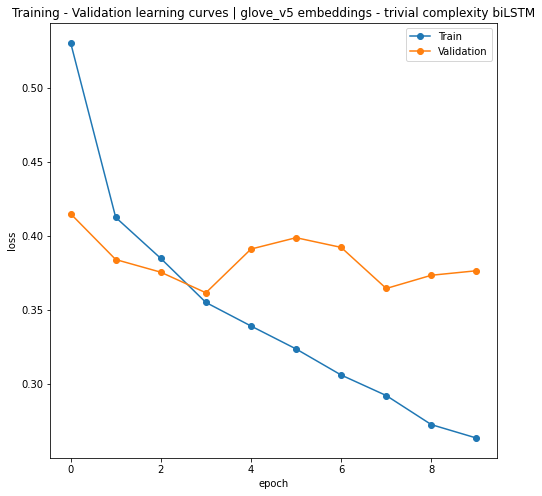

[I 2023-01-13 21:51:02,853] Trial 5 finished with value: 0.36168971928683197 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 67, 'num_lstm_layers': 1, 'lstm_dropout': 0.2998206917347471, 'dropout_rate': 0.39395242830865707, 'n_layers': 1, 'n_units_hidden_layer_0': 52, 'optimizer': 'Adam', 'lr': 0.009718394753726798, 'wd': 1.7540264266554374e-05, 'clip_coef': 2.349685503612267}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 72, batch_first=True, dropout=0.2993531916815294, bidirectional=True)
  (dropout_layer): Dropout(p=0.37332291595865635, inplace=False)
  (output_layer): Linear(in_features=144, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 71,569 trainable parameters

Calculating train/validation loss using: BCELoss()


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2993531916815294 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch-1 lr: 0.0075116011913250276

Epoch: 01 | Epoch Time: 4m 0s
	Train Loss: 0.612
	 Val. Loss: 0.496
Epoch-2 lr: 0.0075116011913250276

Epoch: 02 | Epoch Time: 1m 37s
	Train Loss: 0.447
	 Val. Loss: 0.405
Epoch-3 lr: 0.0075116011913250276

Epoch: 03 | Epoch Time: 1m 40s
	Train Loss: 0.388
	 Val. Loss: 0.417
Epoch-4 lr: 0.0075116011913250276

Epoch: 04 | Epoch Time: 1m 45s
	Train Loss: 0.360
	 Val. Loss: 0.373
Epoch-5 lr: 0.0075116011913250276

Epoch: 05 | Epoch Time: 1m 48s
	Train Loss: 0.346
	 Val. Loss: 0.363
Epoch-6 lr: 0.0075116011913250276

Epoch: 06 | Epoch Time: 1m 53s
	Train Loss: 0.331
	 Val. Loss: 0.371
Epoch-7 lr: 0.0075116011913250276

Epoch: 07 | Epoch Time: 1m 57s
	Train Loss: 0.314
	 Val. Loss: 0.398
Epoch-8 lr: 0.0075116011913250276

Epoch: 08 | Epoch Time: 2m 0s
	Train Loss: 0.304
	 Val. Loss: 0.349
Epoch-9 lr: 0.0075116011913250276

Epoch: 09 | Epoch Time: 2m 4s
	Train Loss: 0.286
	 Val. Loss: 0.359
Epoch-10 lr: 0.0075116011913250276

Epoch: 10 | Epoch Time: 2m 8s
	

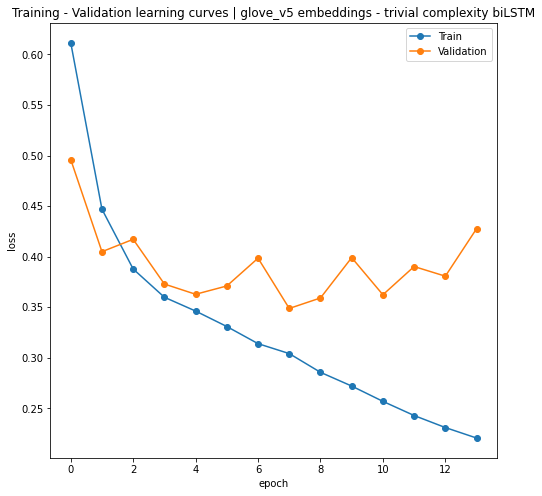

[I 2023-01-13 22:21:09,740] Trial 6 finished with value: 0.34871833297339355 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 72, 'num_lstm_layers': 1, 'lstm_dropout': 0.2993531916815294, 'dropout_rate': 0.37332291595865635, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0075116011913250276, 'wd': 4.5612181522336275e-05, 'clip_coef': 4.437960915783528}. Best is trial 0 with value: 0.32427659698508005.

 SentimentClassifier_baseline_biLSTM_glove_v5(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biLSTM): LSTM(50, 104, num_layers=2, batch_first=True, dropout=0.17252589512940497, bidirectional=True)
  (dropout_layer): Dropout(p=0.519137272992507, inplace=False)
  (output_layer): Linear(in_features=208, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 391,249 trainable parameters

Calculating train/validation loss using: BCELoss()
Epoch-1 lr: 0.0057651276101069815

Epoch: 01 | Epoch Time: 18m 39s
	Train Loss: 0.599
	 Val. L

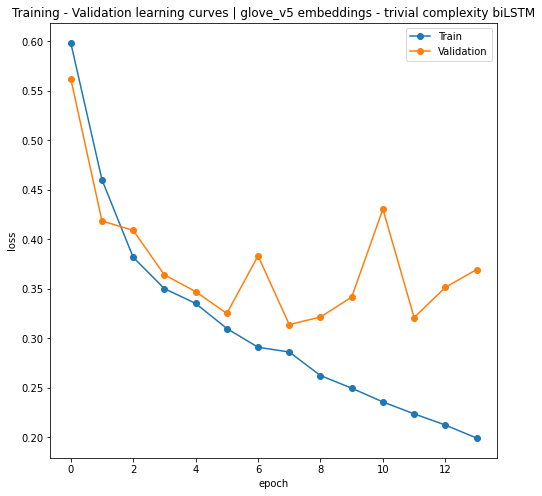

[I 2023-01-14 03:18:54,608] Trial 7 finished with value: 0.31386267800222745 and parameters: {'activation': 'ReLU', 'lstm_hidden_units': 104, 'num_lstm_layers': 2, 'lstm_dropout': 0.17252589512940497, 'dropout_rate': 0.519137272992507, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0057651276101069815, 'wd': 4.5017855681402544e-05, 'clip_coef': 3.2162893888268353}. Best is trial 7 with value: 0.31386267800222745.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove_v5"
complexity = "trivial"
method = "biLSTM"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=None
)

study.optimize(trial_validation_loss, n_trials=8, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.pt")


Study statistics: 
  Number of finished trials:  8
  Number of pruned trials:    0
  Number of complete trials:  8

Best trial: 

Best model validation loss value: 0.31386267800222745

Best trial number: 7

Best model parameters: 

activation: ReLU

lstm_hidden_units: 104

num_lstm_layers: 2

lstm_dropout: 0.17252589512940497

dropout_rate: 0.519137272992507

n_layers: 0

optimizer: Adam

lr: 0.0057651276101069815

wd: 4.5017855681402544e-05

clip_coef: 3.2162893888268353


Evaluation metrics: glove_v5_embeddings_trivial_complexity_nn_biLSTM 
Best parameters: | activation: ReLU | lstm_hidden_units: 104 | num_lstm_layers: 2 | lstm_dropout: 0.17252589512940497 | dropout_rate: 0.519137272992507 | n_layers: 0 | optimizer: Adam | lr: 0.0057651276101069815 | wd: 4.5017855681402544e-05 | clip_coef: 3.2162893888268353 

precision score: 0.8914 
recall_score: 0.8207 
roc score: 0.8604 
f1_score: 0.8546

model bias: 0.0032
model variance: 0.2484


              precision    recall  f1-score   support

    negative       0.83      0.90      0.87      2700
    positive       0.89      0.82      0.85      2700

    accuracy                           0.86      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.86      0.86      0.86      5400





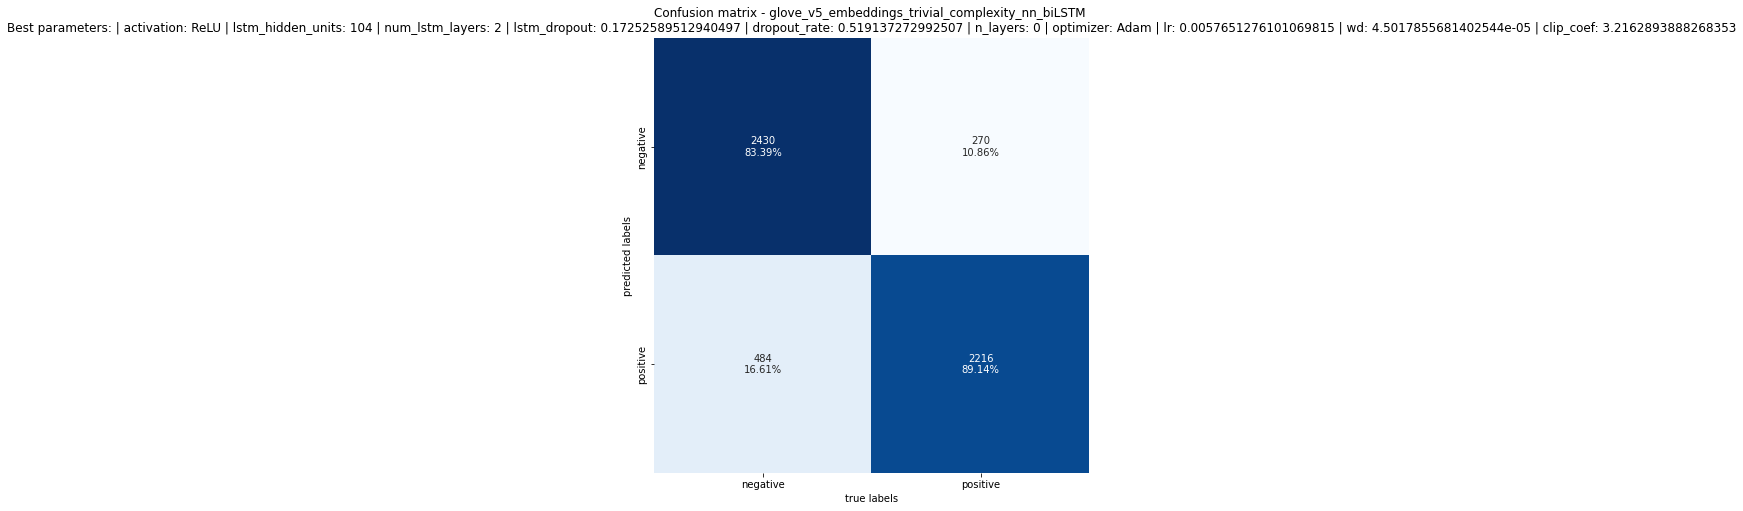

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = f"{embeddings_type}_embeddings_{complexity}_complexity_nn_{method} \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

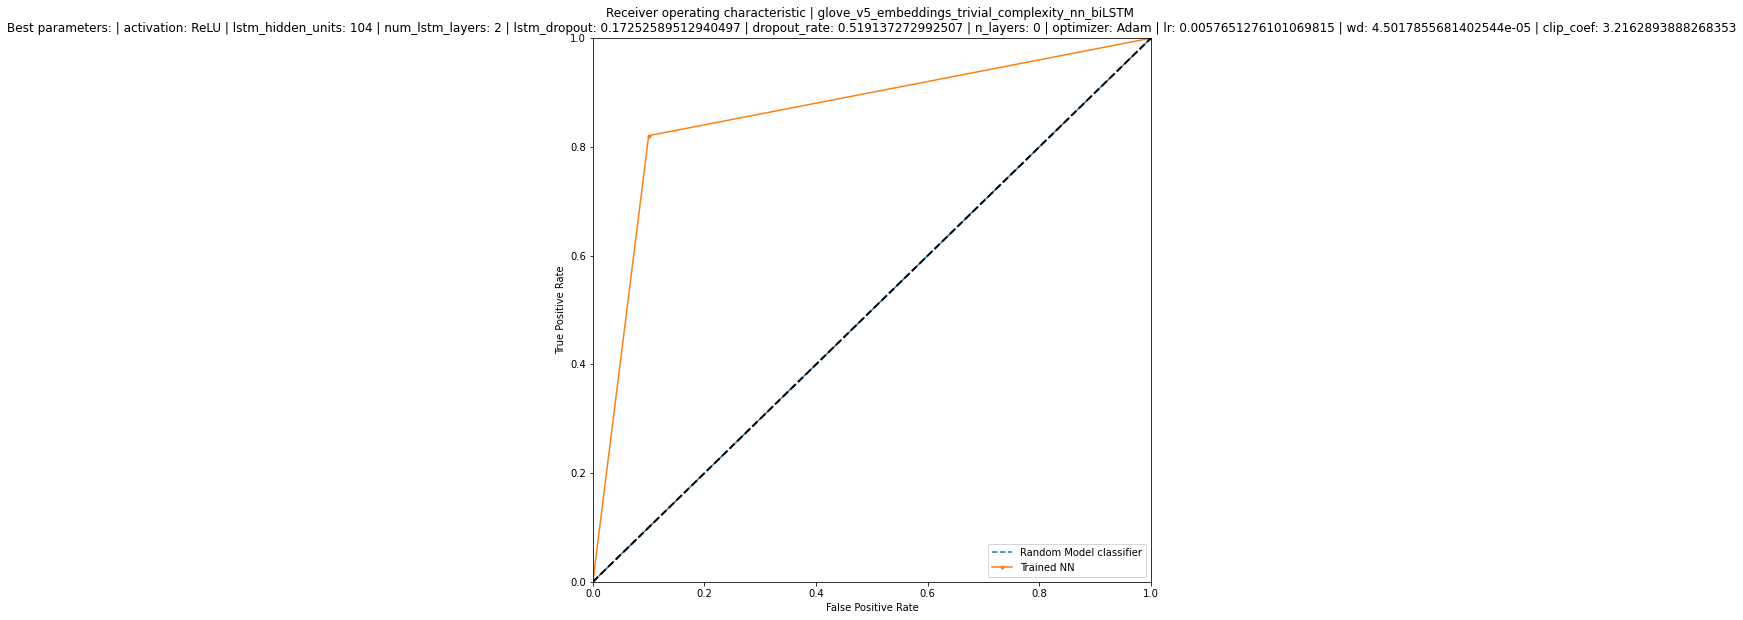

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---
### Advanced complexity model - GloVe embeddings v6

After the experimentation with the baseline model I will proceed the hyper-parameter tuning of the baseline model architecture by also adding extra Linear layers as a hyper-parameter. For example, in the baseline model architecture I had only 1 ```nn.Linear``` layer. In the hyper-parameter tuning I will also test different scenarios with additional linear layers.

You may find below a brief description of the hyper-parameters tuned:
- gru_hidden_units
- num_gru_layers = number of stacked gru layers
- gru_dropout
- n_layers = number of hidden/dense ```nn.Linear``` layers
- gru_hidden_units = hiddent units of the linear layers
- dropout_propability of dropout layer
- activation function of the hidden layers
- learning rate
- weight decay if the learning rate
- clip coef of the gradient clipping method

In [12]:
class SentimentClassifier_baseline_biGRU_glove_v6(nn.Module):

  def __init__(self, trial, non_contributive_token, output_dim, activation, batch_size, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_baseline_biGRU_glove_v6, self).__init__()

    self.layers = []
    self.padding_idx = non_contributive_token

    #embedding layer
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=self.padding_idx)

    #bidirectional LSTM layer
    self.gru_hidden_units = trial.suggest_int("gru_hidden_units", 64, 128)
    self.num_gru_layers = trial.suggest_int("num_gru_layers", 1, 3)
    self.gru_dropout = trial.suggest_float("gru_dropout", 0.15, 0.35)
    #linear_hidden_units = trial.suggest_int("linear_hidden_units", 128, 256)

    self.biGRU = nn.GRU(
      input_size = embedding_dimension,
      hidden_size = self.gru_hidden_units,
      num_layers = self.num_gru_layers,
      batch_first = True,
      dropout = self.gru_dropout,
      bidirectional = True
    )
    self.num_directions = 2 #for bidirectional models.

    #dropout layer
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_layer = nn.Dropout(self.dropout_rate)

    #Specify number of additional dense/linear layers
    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers !=0:
      
      for i in range(self.n_layers):

        out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 16, 64)
        
        if i == 0:
          linear_hidden_units = self.gru_hidden_units*self.num_directions
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
          linear_hidden_units = out_features
        else:
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
        #self.layers.append(nn.BatchNorm1d(3*out_features))
        
        if activation.lower() == "relu":
            self.layers.append(nn.ReLU())
        else:
            self.layers.append(nn.Tanh())
        
        self.layers.append(nn.Dropout(self.dropout_rate))
        linear_hidden_units = out_features
    
    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #output layer
    if self.n_layers !=0:
      self.output_layer = nn.Linear(linear_hidden_units, output_dim)
    else:
      self.output_layer = nn.Linear(self.gru_hidden_units*self.num_directions, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      n = module.in_features
      initrange = 1.0/np.sqrt(n)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        #module.bias.data.zero_()
        module.bias.data.fill_(0)
  
  def init_hidden(self, batch_size):
    
    weight = next(self.parameters()).data
    hidden = weight.new(self.num_gru_layers * self.num_directions, batch_size, self.gru_hidden_units).zero_()

    return hidden

  def forward(self, text, hidden):
    """
    source (1): https://blog.floydhub.com/gru-with-pytorch/
    """
    batch_size = text.size(0)

    embedded = self.embedding(text)

    gru_out, hidden = self.biGRU(embedded, hidden)

    if self.n_layers !=0:
      for layer in range(len(self.layers)):
        if layer ==0:
          dense_layer = self.layers[layer](gru_out)
        else:
          dense_layer = self.layers[layer](dense_layer)
      output_layer = self.output_layer(dense_layer)
    else:
      output_layer = self.output_layer(gru_out)

    output_layer_predictions = self.activation_output(output_layer)

    sig_out = output_layer_predictions[:, -1]
    
    return sig_out, hidden

In [ ]:
seed = 20
def objective(trial):
  torch.manual_seed(seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_baseline_biGRU_glove_v6(
    trial,
    non_contributive_token=glove_vocab_50_v2[unk_token],
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors_50_v2.vectors,
    embedding_dimension=glove_vectors_50_v2.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam"])
  learning_rate = trial.suggest_float('lr', 5e-3, 1e-2)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  clip_coef = trial.suggest_float('clip_coef', 1.5, 5.5)

  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.85)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 50
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train_rnn(model, train_loader, optimizer, loss_func, batch_size_train, clip_coef, train_losses)
    valid_loss = evaluate_rnn(model, valid_loader, loss_func, batch_size_validation, validation_losses)

    scheduler.step()
    print(f"\nEpoch: {epoch:02} | lr: {optimizer.param_groups[0]['lr']}")

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove_v6"
    complexity = "advanced"
    method = "biGRU"
    torch.save(
      model.state_dict(),
      f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_{trial.number+4}.pt"
    )

    boolean = False
    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f}')
    print(f'\t Val. Loss: {valid_loss}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = f"{embeddings_type} embeddings - {complexity} complexity {method}"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2023-01-16 13:48:32,938] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove_v6 embeddings
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/4 [00:00<?, ?it/s]


 SentimentClassifier_baseline_biGRU_glove_v6(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biGRU): GRU(50, 102, num_layers=3, batch_first=True, dropout=0.32830614589494156, bidirectional=True)
  (dropout_layer): Dropout(p=0.657918738653842, inplace=False)
  (output_layer): Linear(in_features=204, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 471,445 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | lr: 0.00845878790879442
Minimum validation loss:  inf
Computed validation loss:  0.4696
Minimum val. loss difference from computed validation loss:  -inf
Epoch: 01 | Epoch Time: 7m 14s
	Train Loss: 0.6603
	 Val. Loss: 0.4696

Epoch: 02 | lr: 0.00845878790879442
Minimum validation loss:  0.4696
Computed validation loss:  0.4295
Minimum val. loss difference from computed validation loss:  -0.0401
Epoch: 02 | Epoch Time: 7m 26s
	Train Loss: 0.4881
	 Val. Loss: 0.4295

Epoch: 03 | lr: 0.008458787

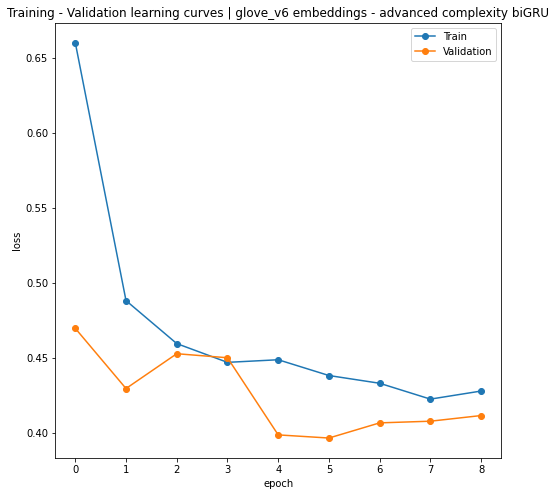

[I 2023-01-16 14:57:59,662] Trial 0 finished with value: 0.3964 and parameters: {'activation': 'ReLU', 'gru_hidden_units': 102, 'num_gru_layers': 3, 'gru_dropout': 0.32830614589494156, 'dropout_rate': 0.657918738653842, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.00845878790879442, 'wd': 3.786809420054082e-05, 'clip_coef': 3.5740437817923225}. Best is trial 0 with value: 0.3964.

 SentimentClassifier_baseline_biGRU_glove_v6(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biGRU): GRU(50, 106, batch_first=True, dropout=0.20446328041331677, bidirectional=True)
  (dropout_layer): Dropout(p=0.6093029668005829, inplace=False)
  (fully_connected_layer_0): Linear(in_features=212, out_features=57, bias=True)
  (fully_connected_layer_1): ReLU()
  (fully_connected_layer_2): Dropout(p=0.6093029668005829, inplace=False)
  (fully_connected_layer_3): Linear(in_features=57, out_features=53, bias=True)
  (fully_connected_layer_4): ReLU()
  (fully_connected_layer_5): Dropout(p=0.6093029668005829

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20446328041331677 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch: 01 | lr: 0.005583468675664476
Minimum validation loss:  inf
Computed validation loss:  0.6931
Minimum val. loss difference from computed validation loss:  -inf
Epoch: 01 | Epoch Time: 5m 21s
	Train Loss: 0.6937
	 Val. Loss: 0.6931

Epoch: 02 | lr: 0.005583468675664476
Minimum validation loss:  0.6931
Computed validation loss:  0.6933
Minimum val. loss difference from computed validation loss:  0.0002
Computed difference in flags array
Patience for early stopping mechanism: 1/3
Epoch: 02 | Epoch Time: 6m 4s
	Train Loss: 0.6933
	 Val. Loss: 0.6933

Epoch: 03 | lr: 0.005583468675664476
Minimum validation loss:  0.6931
Computed validation loss:  0.6932
Minimum val. loss difference from computed validation loss:  0.0001
Computed difference in flags array
Patience for early stopping mechanism: 2/3
Epoch: 03 | Epoch Time: 5m 20s
	Train Loss: 0.6932
	 Val. Loss: 0.6932

Epoch: 04 | lr: 0.005583468675664476
Minimum validation loss:  0.6931
Computed validation loss:  0.6932
Minimum val. 

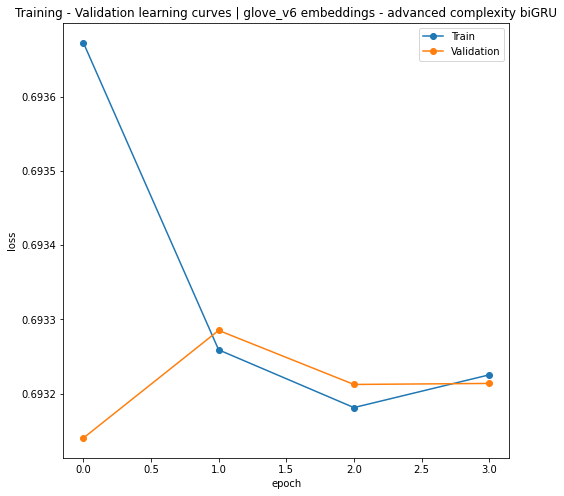

[I 2023-01-16 15:19:26,530] Trial 1 finished with value: 0.6931 and parameters: {'activation': 'ReLU', 'gru_hidden_units': 106, 'num_gru_layers': 1, 'gru_dropout': 0.20446328041331677, 'dropout_rate': 0.6093029668005829, 'n_layers': 3, 'n_units_hidden_layer_0': 57, 'n_units_hidden_layer_1': 53, 'n_units_hidden_layer_2': 17, 'optimizer': 'Adam', 'lr': 0.005583468675664476, 'wd': 7.51280699487701e-05, 'clip_coef': 2.456872864798438}. Best is trial 0 with value: 0.3964.

 SentimentClassifier_baseline_biGRU_glove_v6(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biGRU): GRU(50, 80, num_layers=3, batch_first=True, dropout=0.3399558052228605, bidirectional=True)
  (dropout_layer): Dropout(p=0.530843429005579, inplace=False)
  (output_layer): Linear(in_features=160, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 295,841 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | lr: 0.008851259665692002
Mi

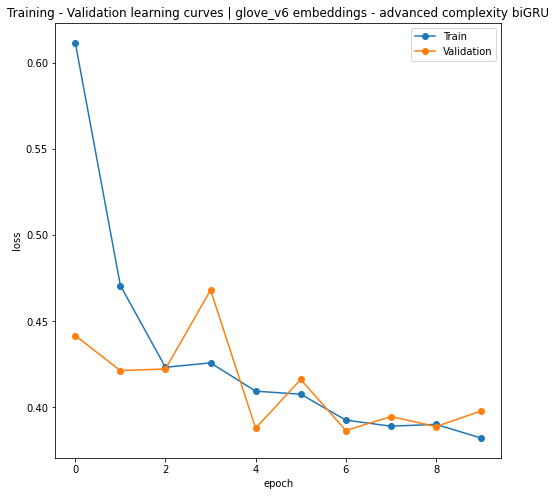

[I 2023-01-16 16:15:28,032] Trial 2 finished with value: 0.3866 and parameters: {'activation': 'ReLU', 'gru_hidden_units': 80, 'num_gru_layers': 3, 'gru_dropout': 0.3399558052228605, 'dropout_rate': 0.530843429005579, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.008851259665692002, 'wd': 4.923810396145495e-05, 'clip_coef': 4.025012262254181}. Best is trial 2 with value: 0.3866.

 SentimentClassifier_baseline_biGRU_glove_v6(
  (embedding): Embedding(100000, 50, padding_idx=0)
  (biGRU): GRU(50, 118, num_layers=2, batch_first=True, dropout=0.24958801466146102, bidirectional=True)
  (dropout_layer): Dropout(p=0.5897055587766253, inplace=False)
  (fully_connected_layer_0): Linear(in_features=236, out_features=29, bias=True)
  (fully_connected_layer_1): ReLU()
  (fully_connected_layer_2): Dropout(p=0.5897055587766253, inplace=False)
  (fully_connected_layer_3): Linear(in_features=29, out_features=19, bias=True)
  (fully_connected_layer_4): ReLU()
  (fully_connected_layer_5): Dropout(p=0.5897

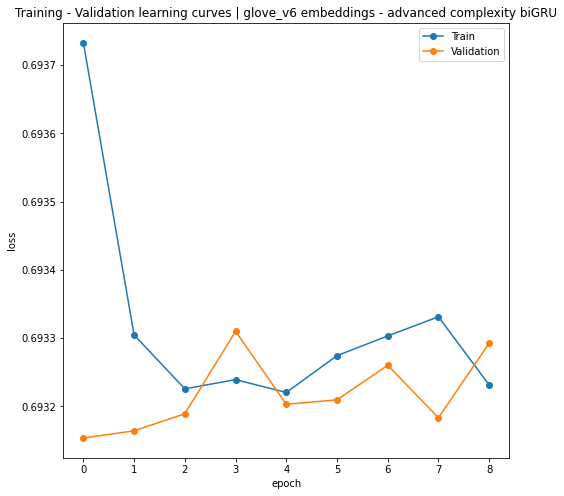

[I 2023-01-16 20:10:13,679] Trial 3 finished with value: 0.6932 and parameters: {'activation': 'ReLU', 'gru_hidden_units': 118, 'num_gru_layers': 2, 'gru_dropout': 0.24958801466146102, 'dropout_rate': 0.5897055587766253, 'n_layers': 2, 'n_units_hidden_layer_0': 29, 'n_units_hidden_layer_1': 19, 'optimizer': 'Adam', 'lr': 0.008857225691792814, 'wd': 4.809841322996459e-05, 'clip_coef': 2.816825630934587}. Best is trial 2 with value: 0.3866.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove_v6"
complexity = "advanced"
method = "biGRU"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=None
)

study.optimize(trial_validation_loss, n_trials=4, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_{embeddings_type}_embeddings_{complexity}_complexity_nn_{method}.pt")


Study statistics: 
  Number of finished trials:  4
  Number of pruned trials:    0
  Number of complete trials:  4

Best trial: 

Best model validation loss value: 0.3866

Best trial number: 2

Best model parameters: 

activation: ReLU

gru_hidden_units: 80

num_gru_layers: 3

gru_dropout: 0.3399558052228605

dropout_rate: 0.530843429005579

n_layers: 0

optimizer: Adam

lr: 0.008851259665692002

wd: 4.923810396145495e-05

clip_coef: 4.025012262254181


Evaluation metrics: glove_v6_embeddings_advanced_complexity_nn_biGRU 
Best parameters: | activation: ReLU | gru_hidden_units: 80 | num_gru_layers: 3 | gru_dropout: 0.3399558052228605 | dropout_rate: 0.530843429005579 | n_layers: 0 | optimizer: Adam | lr: 0.008851259665692002 | wd: 4.923810396145495e-05 | clip_coef: 4.025012262254181 

precision score: 0.7975 
recall_score: 0.9010 
roc score: 0.8361 
f1_score: 0.8461

model bias: 0.0084
model variance: 0.2458


              precision    recall  f1-score   support

    negative       0.89      0.77      0.82      2688
    positive       0.80      0.90      0.85      2688

    accuracy                           0.84      5376
   macro avg       0.84      0.84      0.84      5376
weighted avg       0.84      0.84      0.84      5376





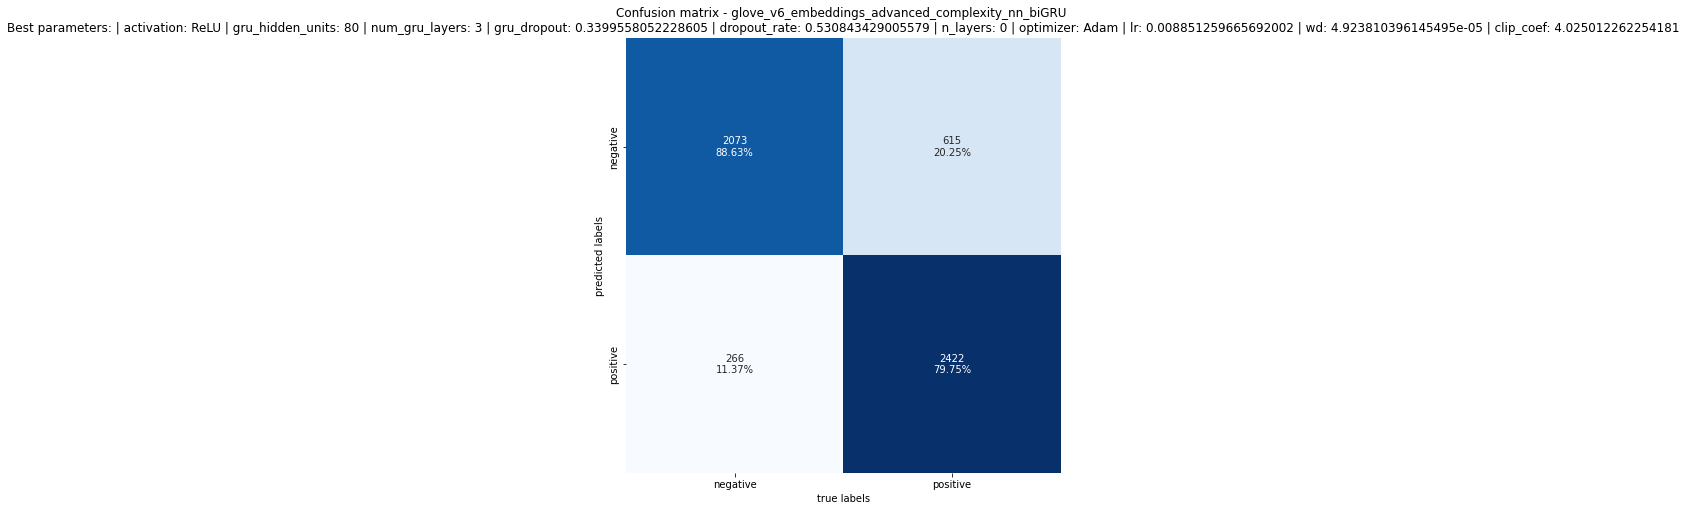

In [13]:
label_names = ["negative", "positive"]

best_model_study=joblib.load("drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_v6_embeddings_advanced_complexity_nn_biGRU_study_optuna.pkl")
trial=best_model_study.best_trial

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

best_model = SentimentClassifier_baseline_biGRU_glove_v6(
    trial,
    non_contributive_token=glove_vocab_50_v2[unk_token],
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors_50_v2.vectors,
    embedding_dimension=glove_vectors_50_v2.dim
  )

best_model.load_state_dict(torch.load("drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/best_glove_v6_embeddings_advanced_complexity_nn_biGRU.pt"))

embeddings_type = "glove_v6"
complexity = "advanced"
method = "biGRU"

graph_name = f"{embeddings_type}_embeddings_{complexity}_complexity_nn_{method} \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name,
  "GRU",
  batch_size_validation
)

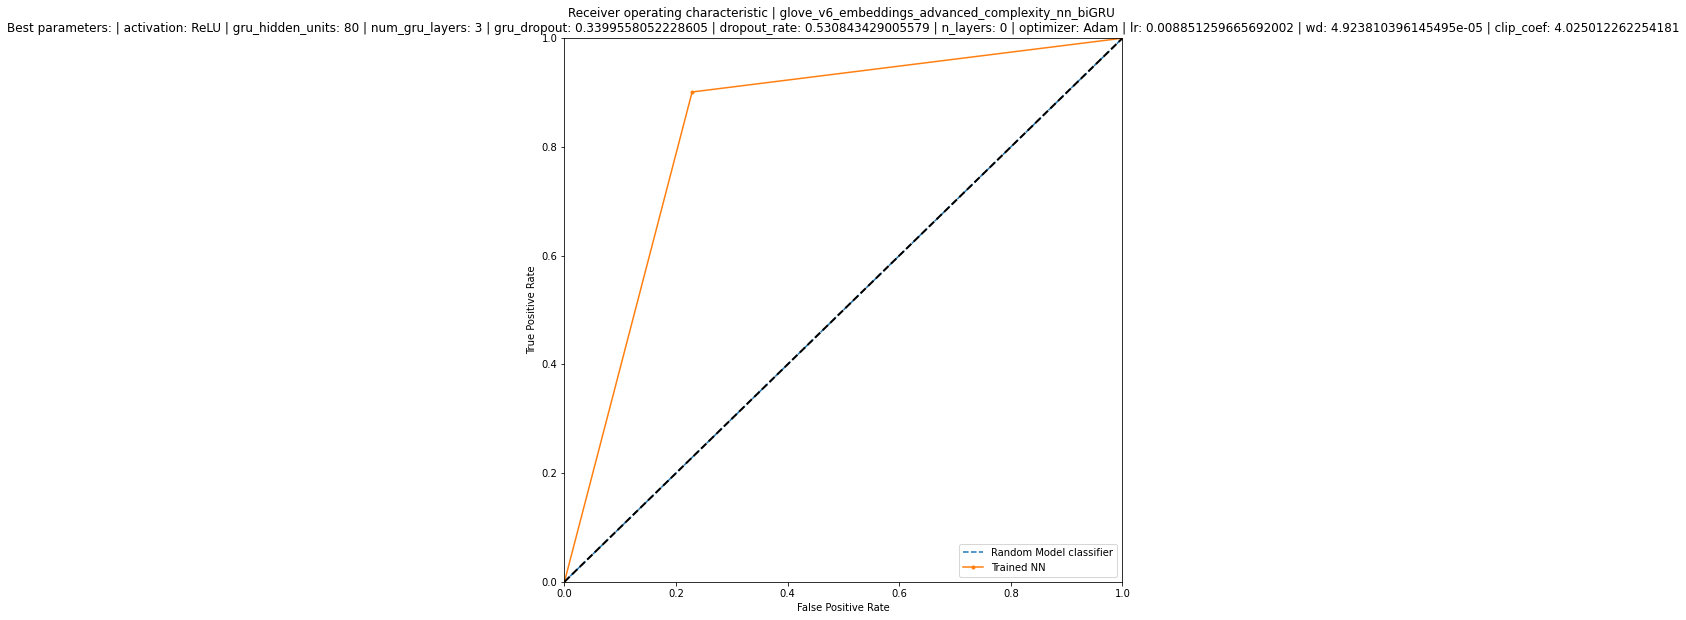

In [14]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

### Evaluate model on grader's data

Before starting:
- Import the libraries (on top of the notebook).
- Execute the code cell with title: *Import & Initialize all the functions used in the experiments* (on top of the notebook).

In [16]:
!pip install --quiet emoji

from tqdm.notebook import tqdm
tqdm.pandas()
import re
import string
import emoji
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

def text_preprocessing(table: pd.DataFrame) -> pd.DataFrame:
  """
  Definition
  ---------
  Apply the text processing methods to clean, normalize text and make it ready for machine learning models.
  The functions applied are: 
    * remove_emoji_characters()
    * transform_abbreviations()
    * remove_stop_words()
    * text_lemmatization()

  Aguments
  ---------
  table: The pandas dataframe to apply the functions.

  Return
  --------
  table: The pandas dataframe with a new column that will be cleaned and normalized. In the code, the new column has the name 'normalized_review'.
         The returned pandas dataframe will have three new columns: processed_review, removed_stopwords_review, normalized_review.
  """

  def remove_emoji_characters(phrase:str) -> str:
    """
    Source
    ---------
    https://stackoverflow.com/a/50602709/10623444

    Definition
    ---------
    Remove emoji characters from the textual content of the dataset. 
    Emoji's cannot be interpreted to a numerical features, plus they don't add any meanigful essence to the text whatsoever. 
    Emoji is an unnecessary form of informantion.

    Aguments
    ---------
    phrase: The string sentence value to remove emojis from it.

    Return
    --------
    Sentence without emojis.
    """
    return emoji.replace_emoji(phrase, replace="")

  def transform_abbreviations(phrase:str) -> str:
    """
    Source
    ---------
    My thesis: https://github.com/NikosSpanos/NLP_Applications/blob/main/multi-label-text-classification-on-movies/Part%203.1%20-%20Data%20Tokenization%20%26%20Sequence%20padding.ipynb

    Definition
    ---------
    Transform abbreviations is a function that will take common english abbreviations likes won't and transform them to their full context such as will not. 
    It would be easier to better clean reviews from common words and punctuations. The function also removes numerical text.

    Aguments
    ---------
    phrase: The string sentence to replace abbreviations from.

    Return
    --------
    Sentence without abbrevaitions.
    """
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"-", " ", phrase) #split words connected with a dash '-'. For example, action-paced => action paced
    phrase = re.sub(r"<br />", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br>", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br >", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br/>", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"http\S+", "", phrase, flags=re.MULTILINE) # remove http(s) hyperlink tags
    phrase = re.sub(r"@\w+", "", phrase, flags=re.MULTILINE) # remove tagged tweeter users (@...)
    phrase = re.sub(r"\d+", "", phrase) # remove digit/numerical characters
    return phrase

  def remove_stop_words(phrase:str) -> str:
    """
    Definition
    ---------
    Remove commonly used words such as articles from the text.
    Stop wodrd occur frequently and don’t contribute much to the overall meaning of the sentence.
    
    Aguments
    ---------
    phrase : A sentence of type string.
    
    Return
    ---------
    phrase: Returns the sentence without the stop_words.
    """
    stop_words = set(stopwords.words('english')) # retrive the list of nltk stop_words
    cleaned_text = [word for word in word_tokenize(phrase.lower()) if word.lower() not in stop_words]

    return " ".join(cleaned_text) # we need to join the sentence because word_tokenize() splits the phrase to single tokens/words

  def text_lemmatization(phrase:str) -> str:
    """
    Definition
    ---------
    Apply lemmatization to the single tokens of a text. Lemmatization will identify the part-of-speech of a word and will replace it with its lemma.
    
    Aguments
    ---------
    phrase : A sentence of type string.
    
    Return
    ---------
    lemmas of phrase: Returns the sentence with lemmatized tokens/words.
    """
    lemmatizer      = WordNetLemmatizer() # initialize nltk lemmatizer method
    lemmatized_text = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in pos_tag(word_tokenize(phrase.lower()))]

    return " ".join(lemmatized_text) # we need to join the sentence because word_tokenize() splits the phrase to single tokens/words

  encoding = 'utf-8'
  
  # Apply functions remove_emoji_characters(), transform_abbreviations()
  table["processed_review"] = table["review"].progress_apply(lambda review: \
                                                              re.sub(" +", " ", \
                                                                  remove_emoji_characters( \
                                                                    transform_abbreviations( \
                                                                      str(review.encode("ascii", "ignore"), encoding) \
                                                                    ) \
                                                                  ).\
                                                                  translate(str.maketrans('', '', string.punctuation)).strip()
                                                                )
                                                              )
  print("\nReviews | After cleaning")
  print(table["processed_review"].iloc[0:3])
  print("\nReviews | Before cleaning")
  print(table["review"].iloc[0:3])

  # Apply function remove_stop_words()
  table["removed_stopwords_review"] = table["processed_review"].progress_apply(lambda review: remove_stop_words(review.lower()))
  
  print("\nReviews | After removing stop words")
  print(table["removed_stopwords_review"].iloc[0:3])
  print("\nReviews | Before removing stop words")
  print(table["processed_review"].iloc[0:3])

  # Apply function text_lemmatization()
  table["normalized_review"] = table["removed_stopwords_review"].progress_apply(lambda review: text_lemmatization(review.lower()))
  
  print("\nReviews | After text normalization-lemmatization")
  print(table["normalized_review"].iloc[0:3])
  print("\nReviews | Before text normalization-lemmatization")
  print(table["removed_stopwords_review"].iloc[0:3])

  return table

# GloVe embeddings - RNN cells best model
class SentimentClassifier_baseline_biLSTM_glove_v2(nn.Module):

  def __init__(self, trial, non_contributive_token, vector_length, output_dim, activation, batch_size, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_baseline_biLSTM_glove_v2, self).__init__()

    self.layers = []
    self.padding_idx = non_contributive_token
    self.vector_length = vector_length

    #embedding layer
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=self.padding_idx)

    #bidirectional LSTM layer
    self.lstm_hidden_units = trial.suggest_int("lstm_hidden_units", 64, 64)
    self.num_lstm_layers = trial.suggest_int("num_lstm_layers", 2, 2)
    self.lstm_dropout = trial.suggest_float("lstm_dropout", 0.15, 0.15)

    self.biLSTM = nn.LSTM(
        input_size = embedding_dimension,
        hidden_size = self.lstm_hidden_units,
        num_layers = self.num_lstm_layers,
        batch_first = True,
        dropout = self.lstm_dropout,
        bidirectional = True
    )
    self.num_directions = 2 #for bidirectional model.

    #Specify number of additional dense/linear layers
    self.n_layers = 0

    #dropout layer
    self.dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.25)
    self.dropout_layer = nn.Dropout(self.dropout_rate)

    #output layer
    self.output_layer = nn.Linear(self.lstm_hidden_units*self.num_directions, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      n = module.in_features
      initrange = 1.0/np.sqrt(n)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        #module.bias.data.zero_()
        module.bias.data.fill_(0)

  def forward(self, text):
    """
    source (1): https://github.com/Huffon/pytorch-sentiment-analysis-kor/blob/master/models/bidirectional_lstm.py
    source (2): https://www.analyticsvidhya.com/blog/2021/09/sentiment-analysis-with-lstm-and-torchtext-with-code-and-explanation/
    """
    embedded = self.embedding(text)

    hidden_state = torch.zeros(self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)
    cell = torch.zeros( self.num_lstm_layers * self.num_directions, text.shape[0], self.lstm_hidden_units)

    out_lstm, (hidden_state, cell) = self.biLSTM(embedded, (hidden_state, cell))
    
    hidden_state = self.dropout_layer(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1))

    output_layer = self.output_layer(hidden_state)
    output_layer_predictions = self.activation_output(output_layer)
    
    return output_layer_predictions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
label_names = ["negative", "positive"]

def grader_scoring(
    data_filepath:str,
    optuna_trial_path:str,
    model_state:str,
    label_names,
    graph_name:str,
    batch_size:int,
    glove_vectors_object:str = None
  ):
  """
  Definition
  ---------
  A method to help the grader score a never-seen-before dataset of movie reviews.

  Aguments
  ---------
  data_filepath : The path were the file with reviews exist. An assumption made is the existense of a column named "review" in the argument passed.
  optuna_trial_path : The path with the study of optuna trials for the selected experiment. Each experiment has a saved study object with 16 to 25 trials. Each trial is a differnt set of hyper-parameters.
  model_state : The path with the saved model state of the best model estimator.
  label_names : The label names of the target sentiment values. Any custom names given by the user.
  graph_name : Name the evaluation report generated.
  batch_size : The batch-size (sentences per batch). Used to create the DataLoader() object.
  glove_vectors_object: The path with the saved glove vectors.

  Output
  ---------
  Evaluation report of the scored samples.
  """ 
  # 1. Import sample
  test_sample = pd.read_csv(os.path.join(os.getcwd(), data_filepath), sep="\t", header=0)

  # 2. Transform target column to binary
  target_column = 'rating'
  conditions = [ (test_sample[target_column] >= 0.0) & (test_sample[target_column] <= 4.0)
                ,(test_sample[target_column] >= 7.0) & (test_sample[target_column] <= 10.0) 
                ]
  choices = [ 0, 1 ]

  test_sample['target'] = np.select(conditions, choices)

  # 3. Text preprocessing
  cleaned_test_sample = text_preprocessing(test_sample)

  # 4. Create iterator sample
  iterator_sample = list(zip(cleaned_test_sample['target'],cleaned_test_sample['normalized_review']))
  target_sentiment = cleaned_test_sample[["target"]].values

  # 5. Load vocabulary
  unk_token = '<unk>' #change that if needed. Keep a note on READme file
  unk_index = 0 #change that if needed

  glove_vectors = load(glove_vectors_object)
  vocab = torchtext.vocab.vocab(glove_vectors.stoi)
  vocab.insert_token(unk_token,unk_index)
  vocab.set_default_index(unk_index)

  # 6. Vectorize data from the vocabulary
  vectors_array = []

  for sentiment, review in tqdm(iterator_sample):
    vector_review_array = []
    for word in review.split(' '):
      if word in vocab:
        vector_review_array.append(vocab[word])
      else:
        vector_review_array.append(vocab[unk_token])
    vectors_array.append(vector_review_array)
  
  # 7. Pad vectors
  padding_value = 165 #(80% of total sentence lengths)
  padded_vectors = padded_sequences(vectors_array, padding_value)

  # 8. Create TensorData object
  test_data = torch.utils.data.TensorDataset(torch.LongTensor(padded_vectors), torch.LongTensor(target_sentiment))

  # 9. Create DataLoader object
  test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
  
  # 10. Load best Optuna trial
  best_model_study=joblib.load(optuna_trial_path)
  trial=best_model_study.best_trial

  model = SentimentClassifier_baseline_biLSTM_glove_v2(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU"]),
    batch_size = batch_size_train,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )
    
  # 11. Load best model state
  model.load_state_dict(torch.load(model_state))

  y_true, y_pred, y_pred_probabilities = nn_evaluation(
    model,
    test_loader,
    label_names,
    np.unique(target_sentiment),
    graph_name,
    "LSTM"
  )

Find the model's state and Optuna best trial in the following shared folder: https://drive.google.com/drive/folders/1K7nkCEv8wGtF2WAwOscCGemmxu2OHnLC?usp=sharing

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After cleaning
0                I really have problems rating this movie It is directed brilliantly there is obviously a lot of money in it Gere and Danes are intense although her screen personality could use a bit more defining and spicing up editing and cinematography are excellent On the other hand it is one of those really really sick movies where one cannot help but wonder whether the director himself likes to stage specific scenes and yes one cannot help but wonder how many copycats will such a movie inspire In purely artistic terms it is a but I really have to ask myself who these people are giving their money to produce such a movie
1                                                                                                                                                                                                                                                                                                                                                   

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After removing stop words
0                         really problems rating movie directed brilliantly obviously lot money gere danes intense although screen personality could use bit defining spicing editing cinematography excellent hand one really really sick movies one help wonder whether director likes stage specific scenes yes one help wonder many copycats movie inspire purely artistic terms really ask people giving money produce movie
1                                                                                                                                                                                                                                                                                       never seen terrible performances life everyone entire film absolute rubbish one decent actoractress whole film joke reminded drama school
2    movies like originals album oriented rock stations music used like repetitive boring drained original energy committee cor

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After text normalization-lemmatization
0                          really problem rating movie direct brilliantly obviously lot money gere dane intense although screen personality could use bit define spice edit cinematography excellent hand one really really sick movie one help wonder whether director like stage specific scene yes one help wonder many copycat movie inspire purely artistic term really ask people give money produce movie
1                                                                                                                                                                                                                                                                          never see terrible performance life everyone entire film absolute rubbish one decent actoractress whole film joke remind drama school
2    movie like original album orient rock station music use like repetitive boring drain original energy committee corporate drone glad aragorn typ

  0%|          | 0/2000 [00:00<?, ?it/s]

Evaluation metrics: GloVe pre-trained embeddings 

precision score: 0.9212 
recall_score: 0.9138 
roc score: 0.9180 
f1_score: 0.9175

model bias: 0.0
model variance: 0.25


              precision    recall  f1-score   support

    negative       0.91      0.92      0.92      1002
    positive       0.92      0.91      0.92       998

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000





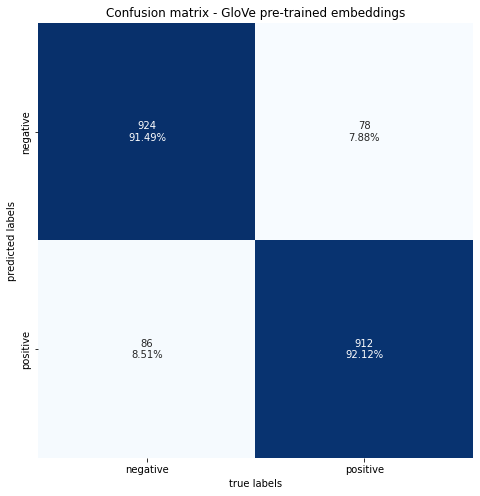

In [20]:
label_names = ["negative", "positive"]
grader_scoring(
    data_filepath = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/test_sample.csv", #(provided by grader)
    optuna_trial_path = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_baseline_v4/glove_v4_embeddings_trivial_complexity_nn_biLSTM_study_optuna.pkl",
    model_state = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_baseline_v4/best_glove_v4_embeddings_trivial_complexity_nn_biLSTM.pt",
    label_names = label_names,
    graph_name = "GloVe pre-trained embeddings",
    batch_size = 256,
    glove_vectors_object = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project III/glove_baseline_v4/glove_vocab.joblib", #(provided by grader-GloVe vectors 50dim 6B- also found in the shared folder)
)